## Chapter 10 Linear multiclass classification

#  10.2  Simultaneous linear multiclass classification

In this Section we discuss a popular alternative to OvA multi-class classification - detailed in the previous Section - where we also learn $C$ two-class classifiers (and also employ the fusion rule) but train them *simultaneously* instead of independently as with OvA. This approach is the direct generalization of two-class classification to the multi-class setting, and so like two-class classification can be derived from a number of perspectives. We will first use the *perceptron* perspective in our derivations, followed by a discussion of the *logistic regression* perspective.  These discussions culminate in the description of a single cost function for multi-class classification that - when minimized properly - provides similar results to OvA. This cost function is widely used and goes by many names, e.g., *multi-class perceptron*,  *multi-class softmax classification*, *softmax regression*, and *multi-class logistic regression*.

In [2]:
# This code cell will not be shown in the HTML version of this notebook
# import custom library
import sys
sys.path.append('../../')
from mlrefined_libraries import superlearn_library as superlearn
from mlrefined_libraries import math_optimization_library as optlib
optimizers = optlib.optimizers
classif_plotter = superlearn.multi_lin_classification_demo
cost_lib = superlearn.cost_functions
normalizers = superlearn.normalizers 
datapath = '../../mlrefined_datasets/superlearn_datasets/'

# standard imports
import matplotlib.pyplot as plt

# import autograd-wrapped numpy
import autograd.numpy as np

# this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

## 10.2.1.  Multiclass perceptron and logistic regression

As we have just seen, in the OvA framework we learn $C$ linear classifiers separately and fuse them afterwards to create a final assignment rule for the entire space. The popular alternative we describe here - a direct generalization of two-class perceptron classifier to the multi-class setting - determines the $C$ classifiers jointly by learning all of their parameters simultaneously using a single function based on the fusion rule.  Given our previous discussion of OvA this is the most natural perspective to take (i.e., examining the classification problem 'from above' as opposed to thinking of it equivalently as a surface fitting nonlinear regression problem), although fundamentally one may equally well begin from the surface fitting logistic regression perspective to derive precisely what we end up with here (just as in the two-class case).

Because we have already done the work in deriving the fusion rule we can derive the basic concept and cost function almost immediately.  We will then see - as with our two-class classification perceptron - that it is common-place to 'soften' the initial cost function to allow for more stable optimization using the softmax approximation.  This leads to a cost function that also arises  *multi-class logistic regression*.

**A note on notation:** In this Section we will purposefully use *semi-compact notation* exclusively in our derivation.  This means we will not append a $1$ to the top of each input $\mathbf{x}_p$, and we separate the bias and normal weights.  For example when we form a linear combination of the an input point as 

\begin{equation}
w_0 + \mathbf{x}_p^T\mathbf{w}^{\,}_{\,}
\end{equation}

we are *explicitly writing the bias term* $w_0$ and the *normal vector* $\mathbf{w} = \begin{bmatrix} w_1 \\ w_2 \\ \vdots \\ w_N\end{bmatrix}$.  We do this for the same reason this semi-compact notation was introduced in Subsection 9.1.5 - because we will naturally need to *regularize* normal vectors $\mathbf{w}$ and this is easier to express using non-compact notation.

## 10.2.2 The multiclass perceptron

Once again we deal with an arbitrary multi-class dataset $\left\{ \left(\mathbf{x}_{p,}\,y_{p}\right)\right\} _{p=1}^{P}$
consisting of $C$ distinct classes of data with label values $y_{p}\in\left\{ 0,1,...,C-1\right\} $.  In the previous Section on OvA multiclass classification we saw how the fusion rule rightfully defined class ownership, partitioning the input space of a dataset given its classes in a fair way.  In particular the fusion rule gives us predicted labels for our dataset, the $p^{th}$ of which $\hat y_p$ given as

\begin{equation}
\hat y_p =  \underset{j \,=\, 0,...,C-1}{\text{argmax}} \,\,\,w_0^{(\,j)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(\,j)}
\end{equation}

where the normal vectors here are assumed to all have unit length, i.e., $\left \Vert \mathbf{w}_{\mathstrut}^{(\,j)} \right \Vert_2^2 = 1$ for all $j$.

For the $p^{th}$ point, ideally we want this prediction to match its true label, i.e., $\hat y_p = y_p$, so that we have

\begin{equation}
w_0^{(y_p)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(y_p)} = \underset{j \,=\, 0,...,C-1}{\text{max}} \,\,\,w_0^{(\,j)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(\,j)}
\end{equation}

Remember geometrically this simply says that the (signed) distance from the point $\mathbf{x}_p$ to its class decision boundary is greater than its distance from every other class's. This is what we want for all of our training datapoints - to have the prediction provided by the fusion rule match our given labels, and hence the above to be true for every point $\mathbf{x}_p$.

Now, suppose we have *not* yet tuned our $C$ two-class classifiers optimally but keep the length of all $C$ normal vectors fixed at $1$ so that we can reliably compute and compare distances to each boundary across the input space. We still know the sort of relationship that we *want* our set of $C$ two-class classifiers to have when optimally tuned.

By definition - when these weights are are tuned optimally - the right hand side of equation (2) must always be greater than or equal to the left, since the $c^{th}$ classifier is considered in the maximum on the right hand side.  This means that their difference - subtracting $ w_0^{(y_p)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(y_p)}$ from both sides - is always greater than or equal to zero

\begin{equation}
\left(\underset{j \,=\, 0,...,C-1}{\text{max}} \,\,\,w_0^{(\,j)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(\,j)}\right) - \left(w_0^{(y_p)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(y_p)}\right) \geq 0
\end{equation}

Note here how strict equality occurs when we have what we want - where the weights $w_0^{(y_p)}$ and $\mathbf{w}_{\mathstrut}^{(y_p)}$ have been tuned correctly so that indeed the $y_p^{th}$ classifier provides the largest evaluation of $\mathbf{x}_p$. And we want equality to occur for all of our datapoints, that is we want their *average* - written as follows - to equal zero (provided the weights of all $C$ classifiers are tuned correctly)

\begin{equation}
g\left(w_0^{(0)},\,\mathbf{w}_{\mathstrut}^{(0)},...,w_0^{(C-1)},\,\mathbf{w}_{\mathstrut}^{(C-1)} \right) = \frac{1}{P}\sum_{p = 1}^P \left[\,\left(\underset{j \,=\, 0,...,C-1}{\text{max}} \,\,\,w_0^{(\,j)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(\,j)}\right) - \left(w_0^{(y_p)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(y_p)}\right) \right]
\end{equation}

We call this the *multi-class perceptron cost* due to the fact that it is a direct generalization of the two-class perceptron. We show in the appendix that when $C = 2$, this cost function reduces to the two-class perceptron. We also prove its convexity in the appendix of this Section.

> The *multiclass perceptron cost* is a direct generalization of the two-class perceptron, and is convex.

Note how in minimizing this cost we should - at least formally - subject it to the constraints that all normal vectors are unit length, i.e., $\left \Vert \mathbf{w}_{\mathstrut}^{(\,j)} \right \Vert_2^2 = 1$ for all $j$. Remember - we need these normal vectors to be unit length if we are to fairly compare the distance of each input $\mathbf{x}_p$ to our two-class decision boundaries.  

Thus, we have a proper *constrained optimization* problem on our hands that formally looks like 

\begin{equation}
\begin{aligned}
\underset{w_0^{(0)},\,\mathbf{w}_{\mathstrut}^{(0)},\,...,\,w_0^{(C-1)},\,\mathbf{w}_{\mathstrut}^{(C-1)}}{\,\,\,\,\,\,\,\,\,\,\,\,\mbox{minimize}\,\,\,} & \,\,\,\, \frac{1}{P}\sum_{p = 1}^P \left[\,\left(\underset{j \,=\, 0,...,C-1} {\text{max}} \,\,\,w_0^{(\,j)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(\,j)} \right) - \left(w_0^{(y_p)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(y_p)}\right) \right]\\
\mbox{subject to}\,\,\, & \,\,\,\,\, \left \Vert \mathbf{w}_{\mathstrut}^{(\,j)} \right \Vert_2^2 = 1, \,\,\,\,\,\, j \,=\, 0,...,C-1
\end{aligned}
\end{equation}

This is a proper cost function for *determining* proper weights for our $C$ classifiers: it is always nonnegative, we want to find weights so that its value is small, and it is precisely zero when all training points are classified correctly.  We can solve such problems directly in a variety of ways - e.g., by using projected gradient descent - but it is more commonplace to see this problem approximately solved by *relaxing the constraints*.

This means we can phrase this constrained problem in an unconstrained *regularized* form by relaxing the constraints but penalizing their magnitude. Because we have $C$ constraints we could in theory provide a distinct penalty (or regularization parameter) $\lambda_j$ for each constraint. However for simplicity one can choose a single regularization parameter $\lambda \geq 0$ that is used to penalize the magnitude of all normal vectors simultaneously. This way we need only provide one regularization value instead of $C$ distinct regularization parameters, giving the regularized form of the above problem as

\begin{equation}
\underset{w_0^{(0)},\,\mathbf{w}_{\mathstrut}^{(0)},...,w_0^{(C-1)},\,\mathbf{w}_{\mathstrut}^{(C-1)}}{\text{minimize}} \,\, \frac{1}{P}\sum_{p = 1}^P \left[\,\left(\underset{j \,=\, 0,...,C-1} {\text{max}} \,\,\,w_0^{(\,j)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(\,j)} \right) - \left(w_0^{(y_p)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(y_p)}\right) \right] + \frac{\lambda}{P} \sum_{j = 0}^{C-1} \left \Vert \mathbf{w}_{\mathstrut}^{(\,j)} \right \Vert_2^2 
\end{equation}

whose objective is once again convex. This regularized form does not quite match the original constrained formulation as regularizing all normal vectors together will not necessarily guarantee that $\left \Vert \mathbf{w}_{\mathstrut}^{(\,j)} \right \Vert_2^2 = 1$ for all $j$.  However it will generally force the length of all normal vectors to behave well, e.g., disallowing one normal vector to grow arbitrarily large while one shrinks to almost nothing. As we see many times in machine learning, it is commonplace to make such compromises to get something that is 'close enough' to the original as long as it does work well in practice. This is indeed the case here with $\lambda$ typically set to a small value (e.g., $10^{-3}$ and smaller).

## 10.2.2  Implementing and minimizing a modular multiclass perceptron in `Python`

One is free to implement the cost function here in a number of ways e.g., as we have done with linear regression and two-class classification in previous Chapters by first implementing a linear `model` function (which here we could do for each individual classifier).  Note however that for efficiency's sake here (i.e., to avoid unnecessary `for` loops in favor of much more efficient `numpy` operations) the particular implementation shown here the weights from all $C$ classifiers are input as an $\left(N + 1\right) \times C$ array of the form

\begin{equation}
\mathbf{W}=\left[\begin{array}{cccc}
w_{0}^{(0)} & w_{0}^{(2)} & \cdots & w_{0}^{(C-1)}\\
w_{1}^{(0)} & w_{1}^{(2)} & \cdots & w_{1}^{(C-1)}\\
\vdots & \vdots & \cdots & \vdots \,\,\,\,\,\, \\
w_{N}^{(0)} & w_{N}^{(2)} & \cdots & w_{N}^{(C-1)}\\
\end{array}\right]
\end{equation}

where the bias and normal vector of the $c^{th}$ classifier have been stacked on top of one another and made the array's $c^{th}$ column.  In this notation we evaluate all $C$ classifiers simultaneously as the $1\times C$ vector

\begin{equation}
\text{model}\left(\mathbf{x},\mathbf{W}\right) = \mathbf{x}^T\mathbf{W}^{\,} = 
\begin{bmatrix}
w_0^{(\,0)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(\,0)}  \, ,
w_1^{(\,1)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(\,1)}  \, ,
\cdots \, ,
w_0^{(\,C-1)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(\,C-1)}
\end{bmatrix}.
\end{equation}

i.e., our entire set of linear (classification) models.  In this extended `model` notation we can more conveniently implement essentially any formula based off of the fusion rule like e.g., the multiclass perceptron.  For example, we can write the fusion rule itself - which for a general input $\mathbf{x}$ is written as $y =  \underset{j \,=\, 0,...,C-1}{\text{argmax}} \,\,\,w_0^{(\,j)} + \mathbf{x}_{\mathstrut}^T\mathbf{w}_{\mathstrut}^{(\,j)}$ - equivalently as 

\begin{equation}
y = \underset{j \,=\, 0,...,C-1} {\text{max}}\,\text{model}\left(\mathbf{x},\mathbf{W}\right).
\end{equation}

In particular we can write the (unregularized) $p^{th}$ summand of the multiclass perceptron compactly as


\begin{equation}
\left(\underset{j \,=\, 0,...,C-1} {\text{max}} \,\,\,w_0^{(\,j)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(\,j)} \right) - \left(w_0^{(y_p)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(y_p)}\right) = \left(\underset{j \,=\, 0,...,C-1} {\text{max}}\,\text{model}\left(\mathbf{x}_p,\mathbf{W}\right)\right) - \text{model}\left(\mathbf{x}_p,\mathbf{W}\right)_{y_p}.
\end{equation}

We implement the multilayer perceptron cost below, beginning with the `model`.  Note that this precisely the same piece of code we used to implement cost functions for both linear regression and two-class classification in the previous two Chapters.  The only difference here is that now we will be inputting the entire weight matrix $\mathbf{W}$ as the variable `w` - i.e., `Python` automatically adjusts to our extended usage of the `model` notion to arrays of weights.

In [8]:
# compute C linear combinations of input point, one per classifier
# this can be written exactly as we have done all other linear models
def model(x,w):
    a = w[0] + np.dot(x.T,w[1:])
    return a.T

Employing this funciton we can then implement a multiclass perceptron in `Python` looping over each point explicitly, as shown below.

In [9]:
# multiclass perceptron regularized by the summed length of all normal vectors
lam = 10**-5  # our regularization paramter 
def multiclass_perceptron(w):        
    # pre-compute predictions on all points
    all_evals = model(x,w)

    # compute counting cost
    cost = 0
    for p in range(len(y)):
        # pluck out current true label
        y_p = y[p] 

        # update cost summand
        cost +=  np.max(all_evals[p,:]) - all_evals[p,int(y_p)]
        
    # return cost with regularizer added
    cost += lam*np.linalg.norm(w[1:,:],'fro')**2
    return cost/float(len(y))

``Python`` code often runs much faster when ``for`` loops - or equivalently ``list comprehensions`` - are written equivalently using matrix-vector ``numpy`` operations (this has been a constant theme in our implementations since linear regression in Section 8.1).  This often leads to more compact ``Python`` code as well, since ``for`` loop operations are often more compactly written (even mathematically) as a matrix-vector operations.

Below we show an example of writing the ``multiclass_perceptron`` cost function more compactly than shown previously using ``numpy`` operations instead of the explicit ``for`` loop over the data points.  Both this and the previous implementation compute the same final result for a given set of input weights, but here the computation will be considerably (orders of magnitude) faster.

In [10]:
lam = 10**-5  # our regularization paramter 
def multiclass_perceptron(w):        
    # pre-compute predictions on all points
    all_evals = model(x,w)
    
    # compute maximum across data points
    a = np.max(all_evals,axis = 0)    

    # compute cost in compact form using numpy broadcasting
    b = all_evals[y.astype(int).flatten(),np.arange(np.size(y))]
    cost = np.sum(a - b)
    
    # add regularizer
    cost = cost + lam*np.linalg.norm(w[1:,:],'fro')**2
    
    # return average
    return cost/float(np.size(y))

#### <span style="color:#a50e3e;">Example 1: </span> Multiclass perceptron

In this example we minimize the regularized multi-class classifier defined above over a toy dataset with $C=3$ classes used in deriving OvA in the previous Section.

<IPython.core.display.Javascript object>


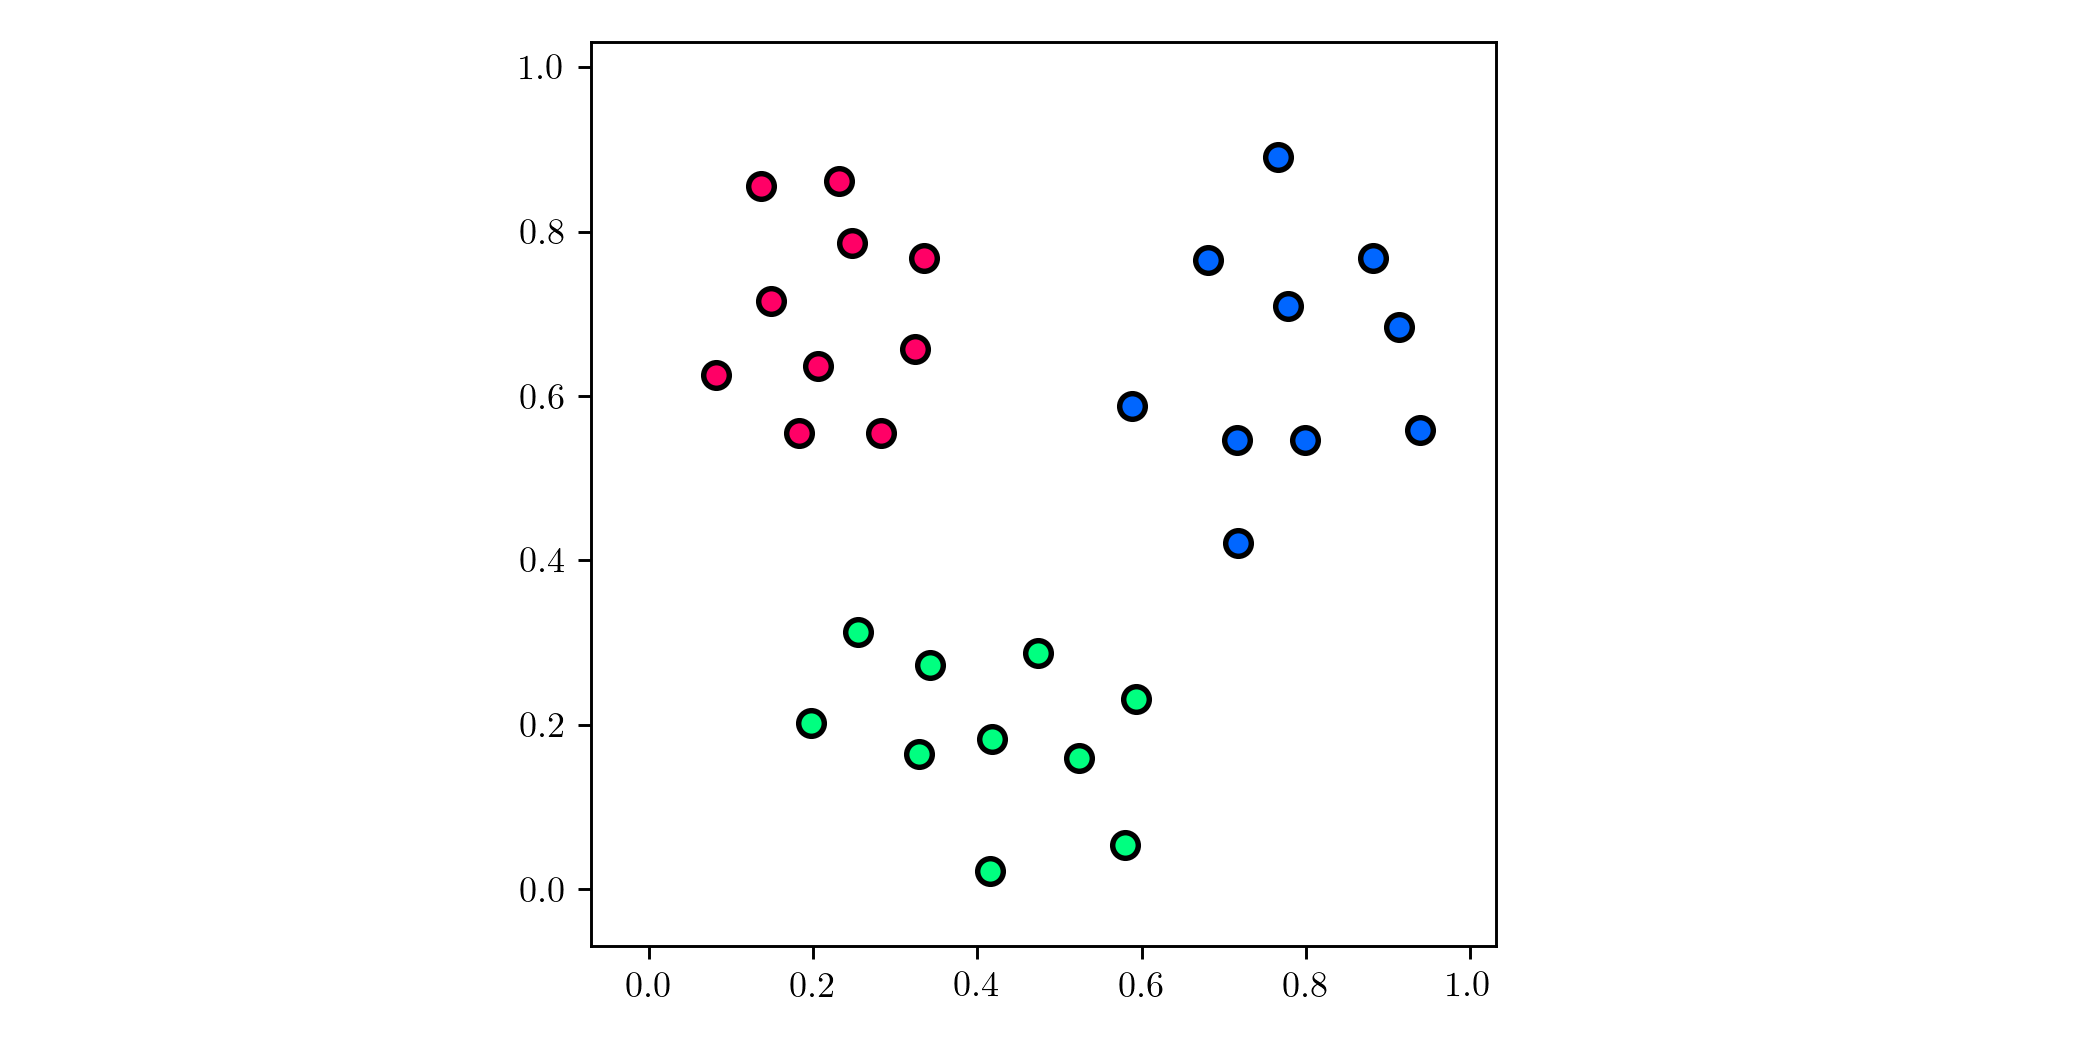

In [15]:
# This code cell will not be shown in the HTML version of this notebook
# load in dataset
data = np.loadtxt(datapath + '3class_data.csv',delimiter = ',')

# create an instance of the ova demo
demo = superlearn.multiclass_illustrator.Visualizer(data)

# get input/output pairs
x = data[:-1,:]
y = data[-1:,:] 

# visualize dataset
demo.show_dataset()

# run gradient descent to minimize cost
g = multiclass_perceptron; w = 0.1*np.random.randn(3,3); max_its = 200; alpha_choice = 10**(-1);
weight_history,cost_history = optimizers.gradient_descent(g,alpha_choice,max_its,w)

With our multi-class classifier trained by gradient descent we now show how it classifies the entire input space. In the left panel we plot each individual two-class classifier. In the middle panel we show the fused multi-class decision boundary formed by combining these individual classifiers via the fusion rule. In the right panel we plot the cost function value over $200$ iterations of gradient descent.

Note in the left panel that because we did not train each individual classifier in an OvA sense - but trained them together all at once - each individual learned two-class classifier performs quite poorly.  This is fine as our cost function aimed at minimizing all errors of every class simultaneously and not two at a time as with OvA - so we need not expect each individual classifier to cut the space well. However since they were learned together their combination - using the fusion rule - provides a multi-class decision boundary with zero errors.

<IPython.core.display.Javascript object>


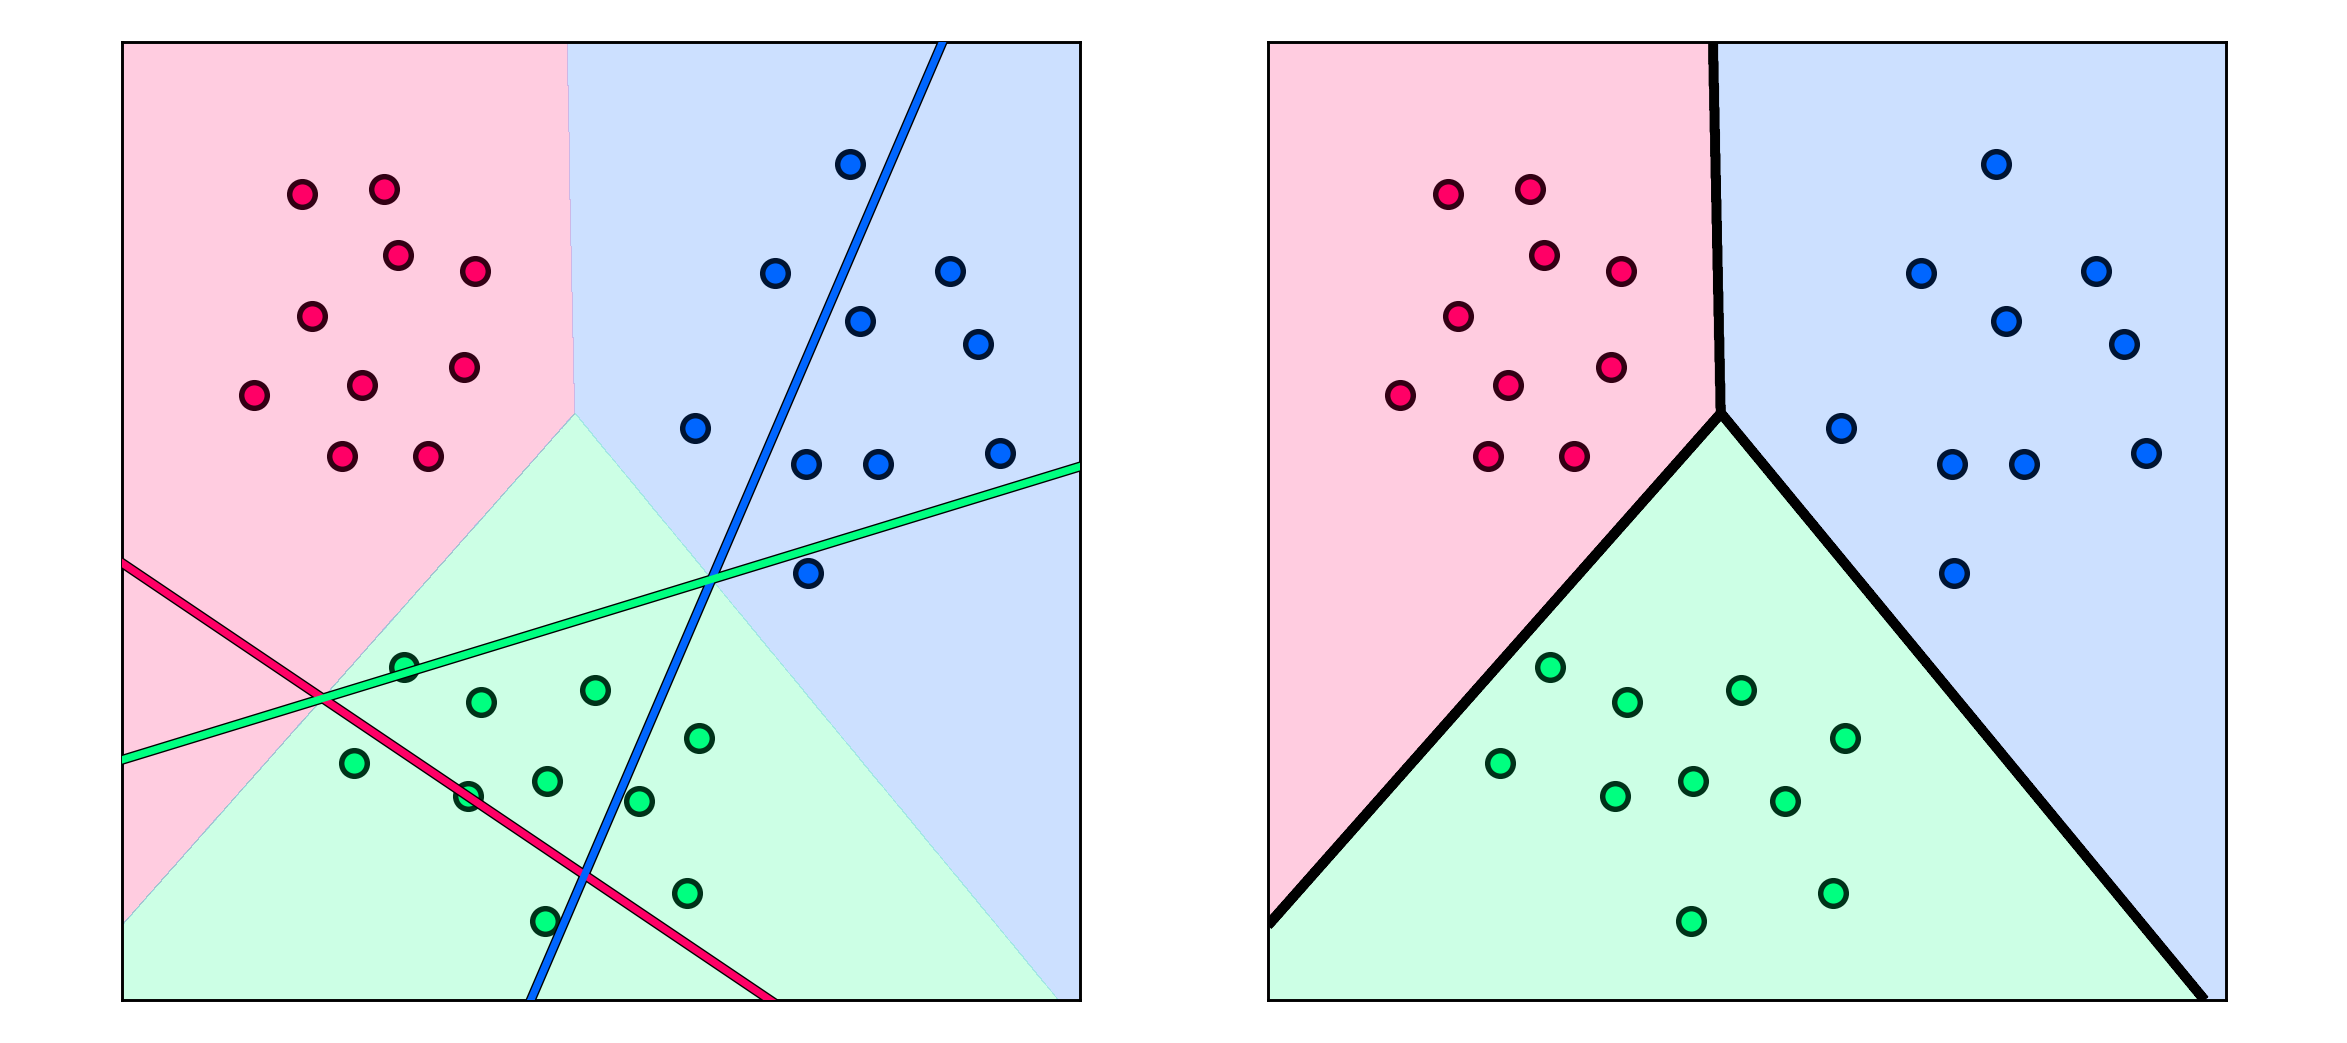

In [16]:
# This code cell will not be shown in the HTML version of this notebook
# plot classification of space, individual learned classifiers (left panel) and joint boundary (middle panel), and cost-function panel in the right panel
demo.show_complete_coloring(weight_history, cost = multiclass_perceptron)

#### <span style="color:#a50e3e;">Example 2: </span>  A toy example illustrating the theoretical superiority of the simultaneous multiclass framework in comparison to OvA

Because the multiclass frameworks we have and will see in this Section aim at directly satisfying the fusion rule by simultaneously tuning every parameter involved, we could (and perhaps should) expect superior performance in comparison to OvA (which aims at indirectly satisfying the fusion rule by combining separate two-class subproblems).  Here we examine a simple example - first described in example 2 of the previous Section - of a single input $C = 4$ class dataset where this does indeed happen.

<IPython.core.display.Javascript object>


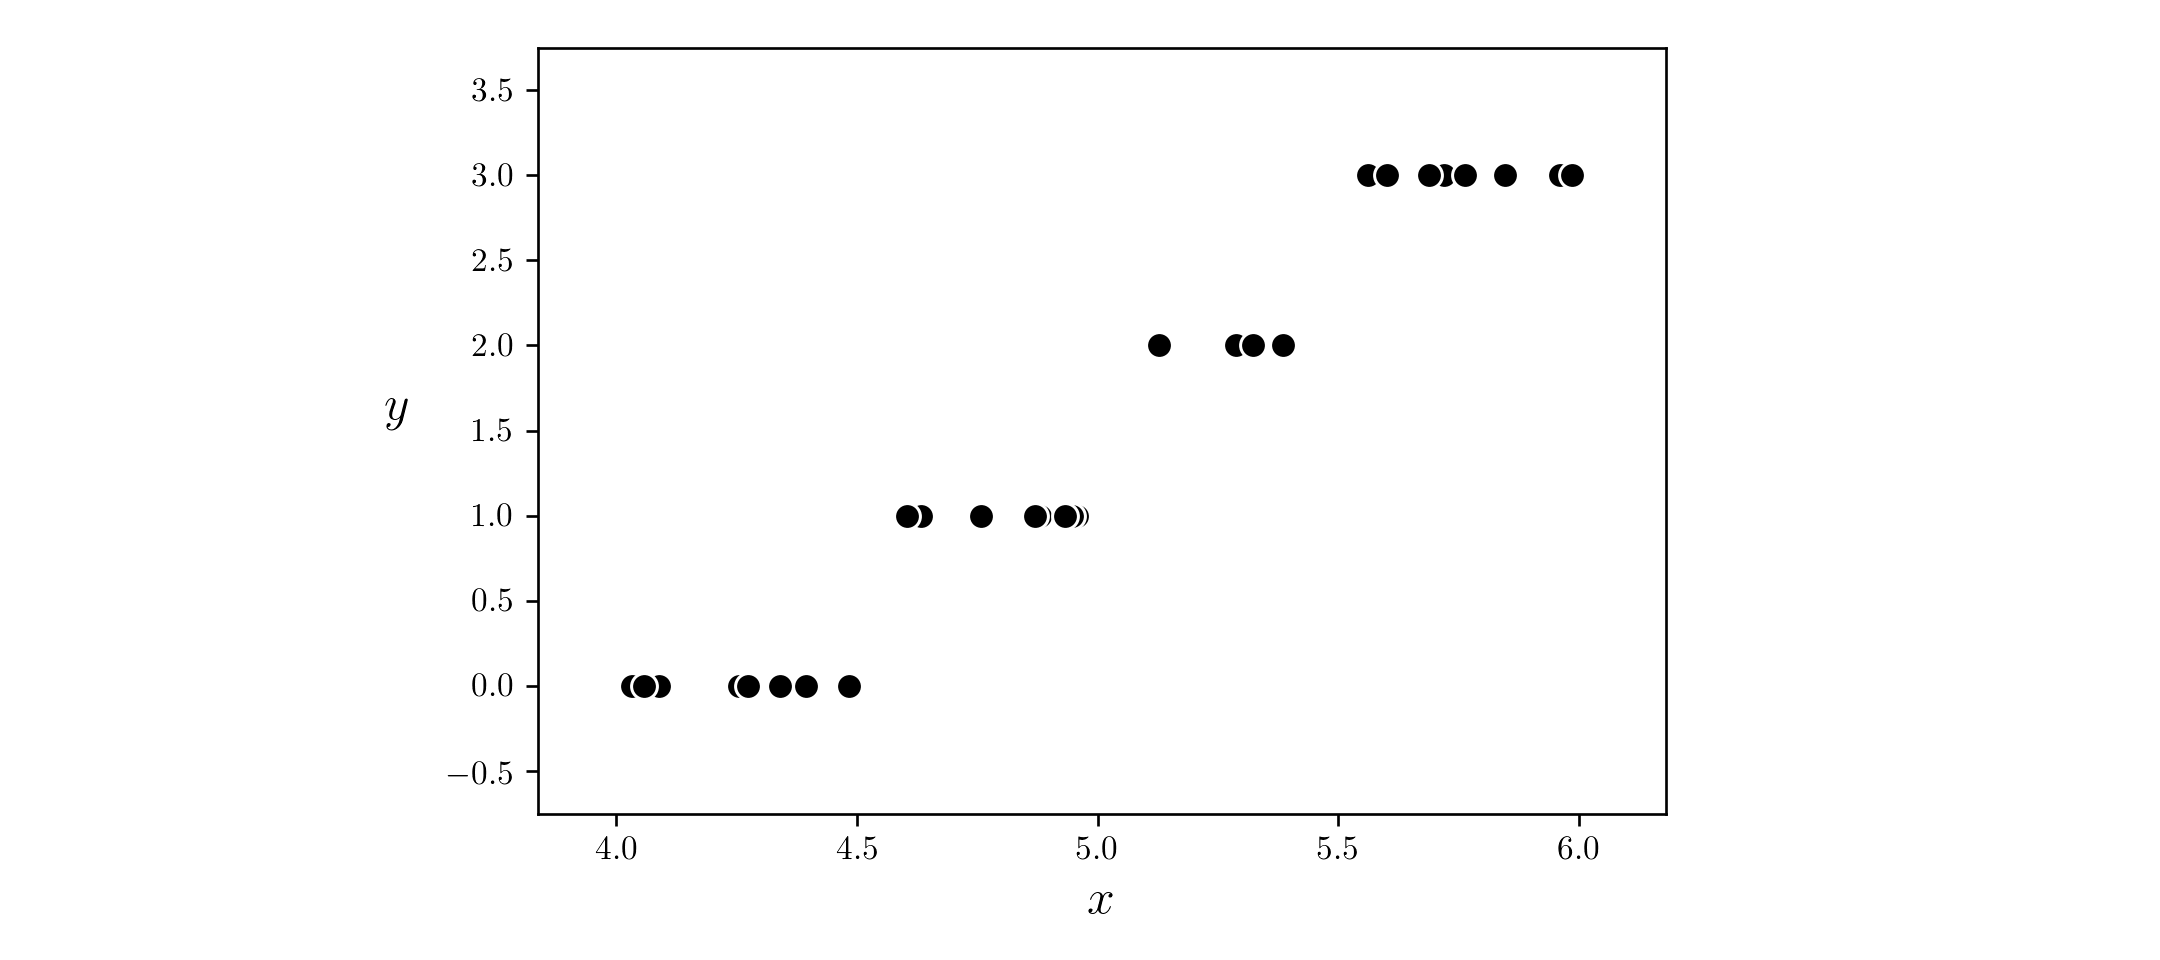

In [56]:
# This code cell will not be shown in the HTML version of this notebook
# load in a toy dataset to illustrate the benefits of standard normalization 
data = np.loadtxt(datapath + 'singleinput_multiclass_dataset.csv',delimiter = ',')

# get input/output pairs
x = data[:-1,:]
y = data[-1:,:] 

# multiclass single-input plotter
demo = classif_plotter.Visualizer(data)
demo.plot_data()

When we introduced this dataset in the previous Section we described how a fully trained linear OvA classifier could never represent it perfectly, since not all of the two-class subproblems could be classified perfectly using a linear two-class classifier.  However in minimizing multiclass perceptron/softmax we take a holistic view of satisfying the fusion rule, simultaneously tuning the parameters of all $C$ classifier, instead of trying to tune them one classifier at a time on two-class subproblems as with OvA . By avoiding these subproblems - in which we seek out perfect results each time on one-versus all versions of our dataset  - we avoid the inherent wall that prevents OvA from performing perfectly on this toy dataset.

Below we take $10,000$ gradient descent steps to optimize the multiclass perceptron cost on this dataset.  Shown afterwards is the multilevel step function - produced by the fusion rule employing the best set of weights found via this procedure - and we can indeed see that we attain perfect results.

<IPython.core.display.Javascript object>


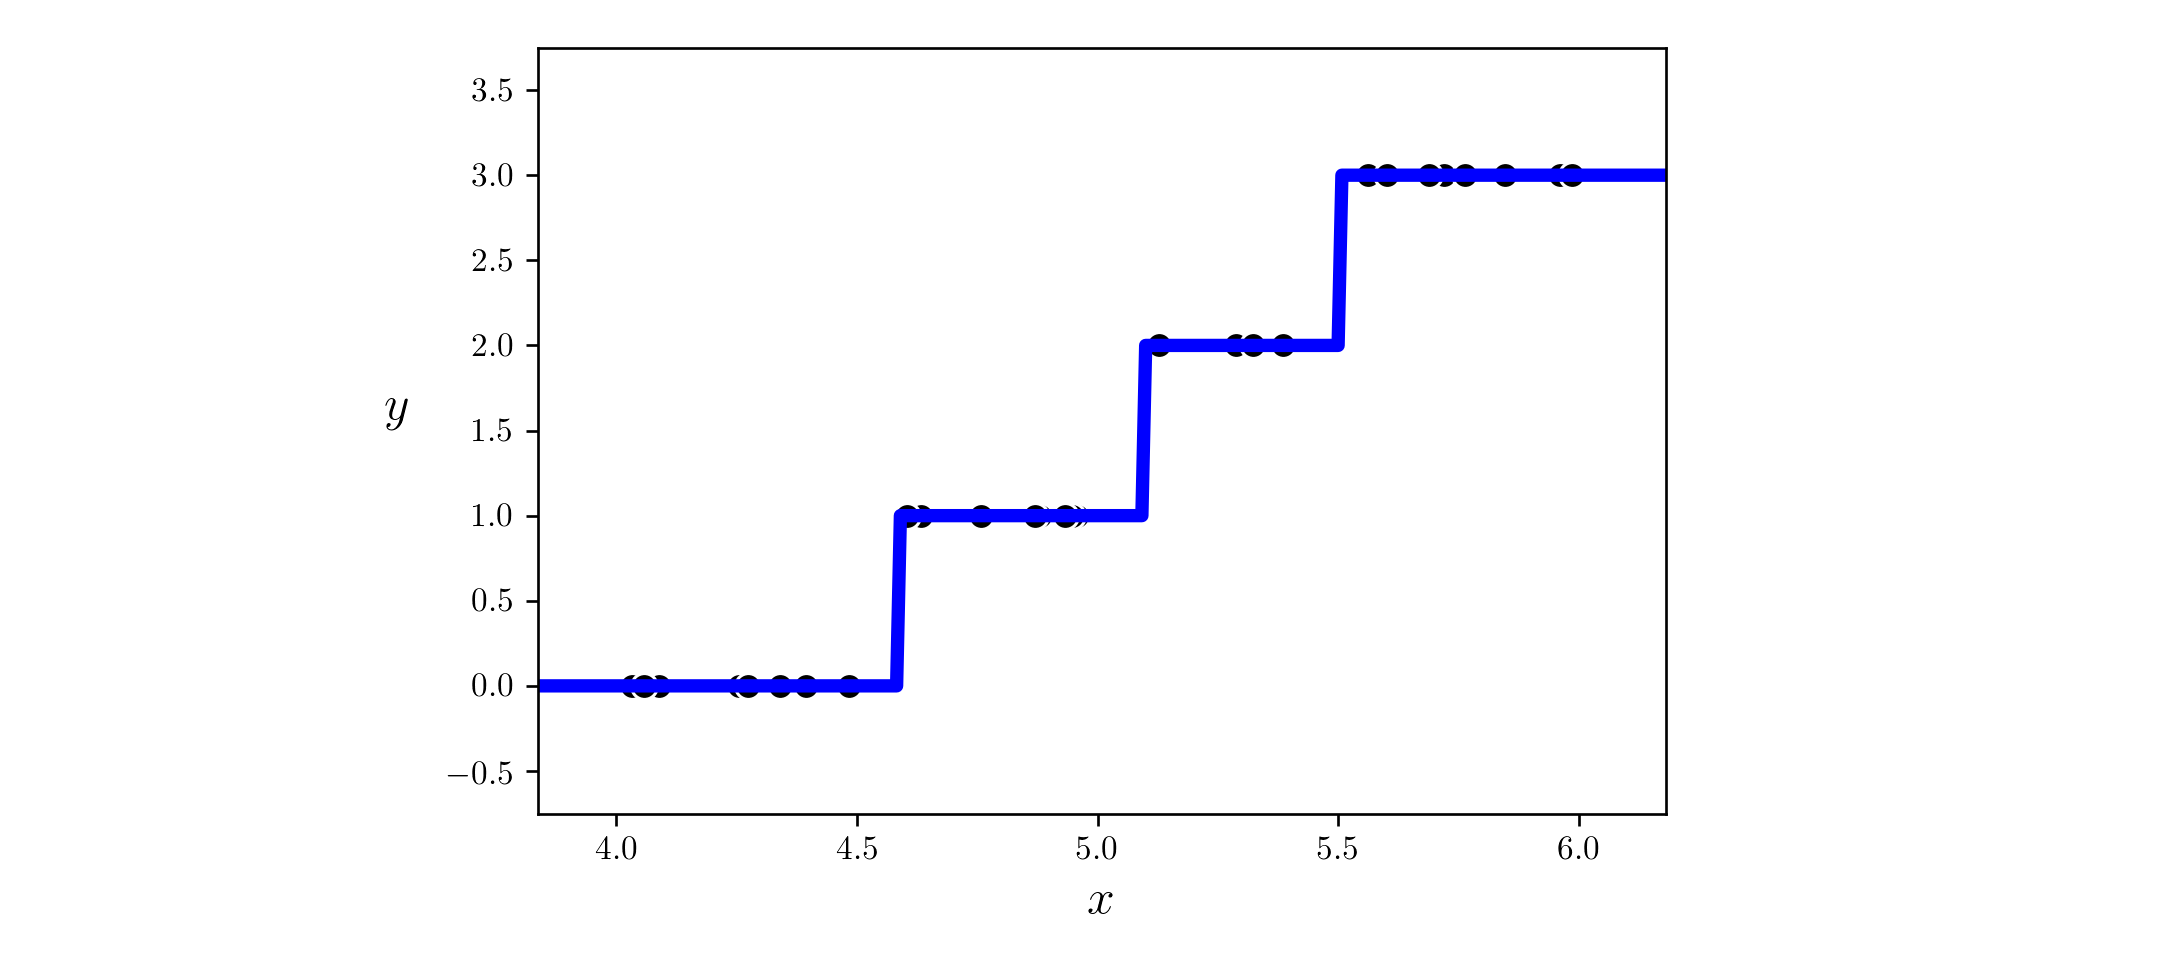

In [59]:
# This code cell will not be shown in the HTML version of this notebook
# run newtons method to minimize cost
g = multiclass_perceptron; w = 0.1*np.random.randn(2,4); max_its = 10000; 
alpha_choice = 10**(-2)
weight_history,cost_history = optimizers.gradient_descent(g,alpha_choice,max_its,w)

# compute misclassification history
counting_cost = cost_lib.choose_cost(x,y,'multiclass_counter')
count_history = [counting_cost(v) for v in weight_history]  # compute misclassification history

# plot the best learned representation from our run above
ind = np.argmin(count_history)
best_weights = weight_history[ind]
demo.plot_fit(best_weights)

If we visualize the results here in the OvA framework - where we plot each fully trained individual classifier along with its one-versus-all version of the data - we can see that indeed none of the individual classifiers does a perfect job of distinguishing one class from all the others.  This is perfectly fine, since we did not force this to hold when setting up the multiclass cost function, and again is in fact what saves us from imperfect classification on the full $C = 4$ class data.

<IPython.core.display.Javascript object>


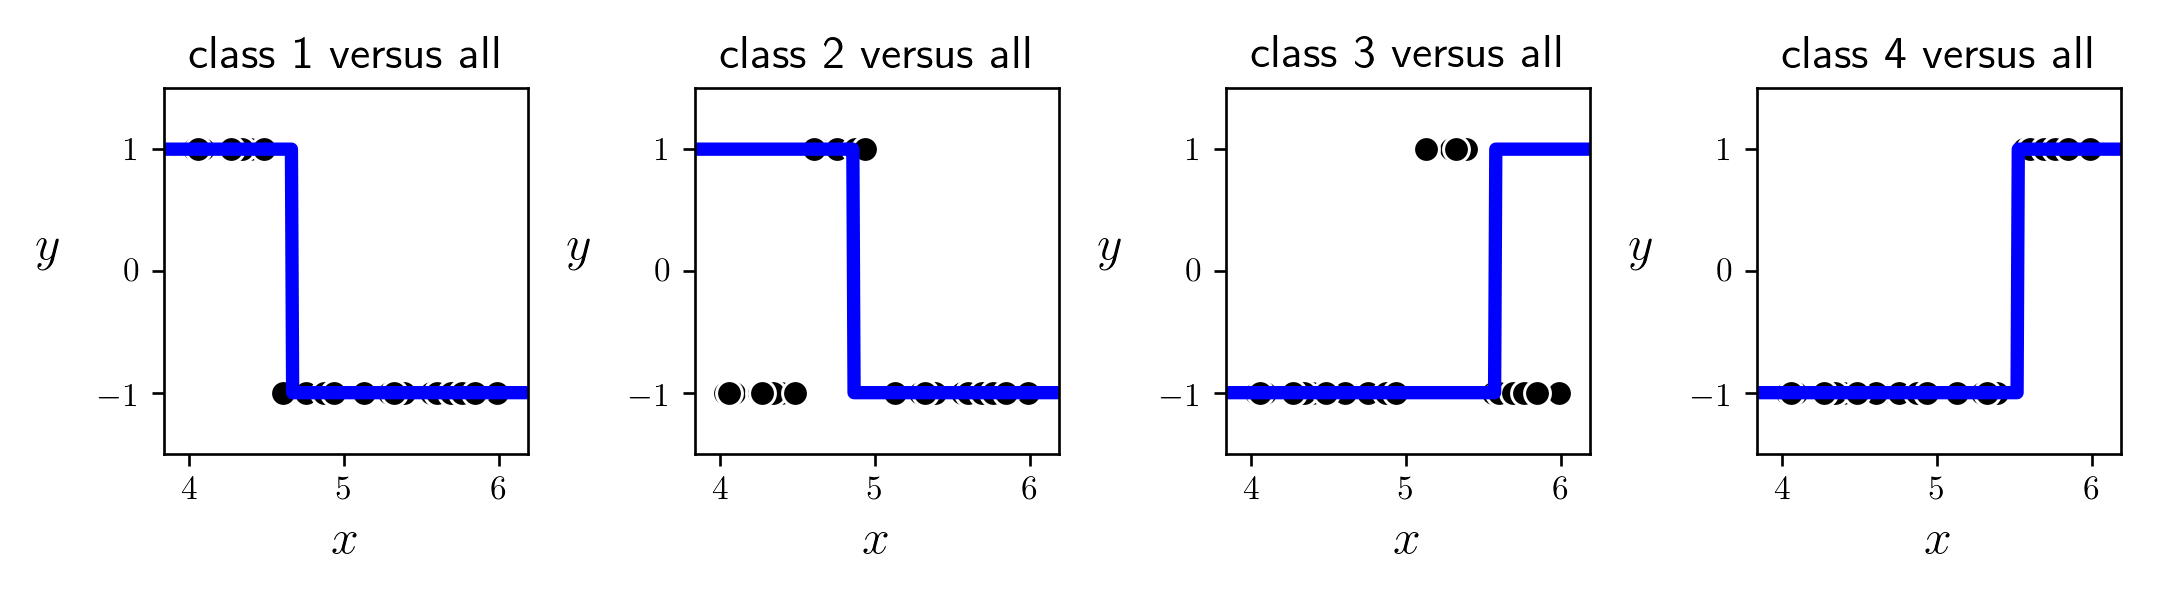

In [60]:
# This code cell will not be shown in the HTML version of this notebook
# visualize each subproblem dataset and step function fit
demo.plot_subproblem_fits(best_weights)

## 10.2.4  The smooth softmax approximation to multiclass perceptron cost

As we saw previously, for instance with the two-class perceptron, we are often willing to sacrifice a small amount of modeling precision - forming a closely matching smoother cost function to the one we already have - in order to make optimization easier or expand the optimization tools we can bring to bear. 

Recall from our discussion of the two-class perceptron that the *softmax function*

\begin{equation}
\text{soft}\left(s_{0},...,s_{C-1}\right)=\text{log}\left(\sum_{j = 0}^{C-1} e^{s_{j}}\right)
\end{equation}

is a close and smooth approximation to the maximum of $C$ scalar numbers $s_{0},...,s_{C-1}$, i.e.,

\begin{equation}
\text{max}\left(s_{0},...,s_{C-1}\right) \approx \text{soft}\left(s_{0},...,s_{C-1}\right)
\end{equation}

Replacing the max function in each summand of the multi-class perceptron cost in equation (4), we have the *softmax multi-class cost function* written as

\begin{equation}
g\left(w_0^{(0)},\,\mathbf{w}_{\mathstrut}^{(0)},...,w_0^{(C-1)},\,\mathbf{w}_{\mathstrut}^{(C-1)} \right) = \frac{1}{P}\sum_{p = 1}^P \left[\text{log}\left( \sum_{j = 0}^{C-1}  e^{ w_0^{(j)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(j)}}  \right) - \left( w_0^{(y_p)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(y_p)}\right)\right]
\end{equation}

As with the mutli-class perceptron, the multi-class softmax cost also reduces to the two-class version when $C = 2$ (see the appendix of this Section for further details). Furthermore, not only is the multi-class softmax cost function convex but - unlike the multi-class perceptron - it has infinitely many smooth derivatives, hence we can use Newton's method (in addition to gradient descent) in order to properly minimize it.

> The multi-class softmax cost reduces to the two-class version when $C = 2$.  Furthermore, not only is the multi-class softmax cost function convex but - unlike the multi-class perceptron - it has infinitely many smooth derivatives, hence we can use Newton's method (in addition to gradient descent) in order to properly minimize it.

One often sees this cost function go by many names - e.g., *softmax regression* and *multi-class logistic regression* - for as with two-class classification the softmax cost can be interpreted from a logistic regression (surface fitting) perspective. One also often sees the cost written in various ways in practice as well - sometimes due to the perspective taken in deriving it, or for numerical stability reasons. A very common alternative way one will see the softmax multi-class cost function written (when thought of from the perspective of logistic regression) can be seen by using basic properties of the log function. Using the following properties 

\begin{equation}
\text{log}\left(s\cdot t\right) = \text{log}\left(s\right) + \text{log}\left(t\right) \\
\text{log}\left(s\right)^{-1} = \text{log}\left(\frac{1}{s}\right)
\end{equation}

one can express the softmax multi-class cost in equation (10) equivalently as

\begin{equation}
g\left(w_0^{(0)},\,\mathbf{w}_{\mathstrut}^{(0)},...,w_0^{(C-1)},\,\mathbf{w}_{\mathstrut}^{(C-1)} \right) = -\frac{1}{P}\sum_{p = 1}^P \text{log}\left(\frac{ e^{ w_0^{(y_p)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(y_p)}} }{ \sum_{j = 0}^{C-1}  e^{ w_0^{(j)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(j)}} }\right)
\end{equation}

 

Care must be taken when implementing any cost function - or mathematical expression in general - involving the exponential function $e^{\left(\cdot\right)}$ in Python. By nature the exponential function grows large very rapidly causing undesired 'overflow' issues even with moderate-sized exponents, e.g., $e^{1000}$. Large numbers like this cannot be stored explicitly on the computer and so are represented symbolically as $\infty$. Additionally, the division of two such large numbers - which is a potentiality when evaluating the summands of the multi-class cost in equation (12) - is computed and stored as a NaN (not a number) causing severe numerical stability issues.

One way we can guard against this issue is by normalizing the data - to fall within a relatively small range - and regularizing the weights, e.g., via their $\ell_2$ norm, to punish/prevent large weight values. While a workable solution, in practice we can still run into overflow issues immediately after initialization especially when input is high-dimensional. It is therefore good practice to implement one's own version of the exponential function by capping the maximum value it can take, as shown below where $G$ is set to a relatively large value that does not send $e^G$ to $\infty$.  

## 10.2.4  Implementing and minimizing a modular multiclass softmax in `Python`

We can make a compact and efficient implementation the multiclass softmax in `Python` by taking our corresponding multiclass perceptron implementation from the previous Section and making a few modifications, as shown below.  In particular we continue to use the compact `model` notation first discussed in 10.2.2, i.e., the $1 \times C$ vector formula

\begin{equation}
\text{model}\left(\mathbf{x},\mathbf{W}\right) = \mathbf{x}^T\mathbf{W}^{\,} = 
\begin{bmatrix}
w_0^{(\,0)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(\,0)}  \, ,
w_1^{(\,1)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(\,1)}  \, ,
\cdots \, ,
w_0^{(\,C-1)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(\,C-1)}
\end{bmatrix}.
\end{equation}

With this notation the $p^{th}$ summand of the multiclass softmax cost as written in e.g., equation (14) compactly as 

\begin{equation}
\text{log}\left( \sum_{j = 0}^{C-1}  e^{ w_0^{(j)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(j)}}  \right) - \left( w_0^{(y_p)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(y_p)}\right) = {\text{soft}}\left(\text{model}\left(\mathbf{x}_p,\mathbf{W}\right)\right) - \text{model}\left(\mathbf{x}_p,\mathbf{W}\right)_{y_p}.
\end{equation}

With this more compact way of expressing the multiclass softmax - and with the module `model` having already been written above - we can quickly implement a `Python` efficient implementation of the multiclass softmax cost.

In [64]:
# multiclass softmaax regularized by the summed length of all normal vectors
lam = 10**(-5)  # our regularization paramter 
def multiclass_softmax(w):        
    # pre-compute predictions on all points
    all_evals = model(x,w)
    
    # compute softmax across data points
    a = np.log(np.sum(np.exp(all_evals),axis = 0)) 
    
    # compute cost in compact form using numpy broadcasting
    b = all_evals[y.astype(int).flatten(),np.arange(np.size(y))]
    cost = np.sum(a - b)
    
    # add regularizer
    cost = cost + lam*np.linalg.norm(w[1:,:],'fro')**2
    
    # return average
    return cost/float(np.size(y))

#### <span style="color:#a50e3e;">Example 3: </span> Multi-class softmax on a toy dataset with $C=3$ classes

In this example we run the multi-class softmax classifier on the same dataset used in the previous example, first using unnormalized gradient descent and then Newton's method.  In the next Python cell we implement a version of the multi-class softmax cost function complete with regularizer. The weights are formatted precisely as in our implementation of the multi-class perceptron, discussed in Example 1.  We then minimize the softmax cost function using gradient descent - for $200$ iterations using a fixed steplength value $\alpha = 10^{-2}$.

Below we plot the final classification over the entire space in the left and middle panels while the cost function plot from our run of gradient descent is plotted in the right panel. In the left panel are shown the final learned two-class classifiers individually, in the middle the multi-class boundary created using these two-class boundaries and the fusion rule. As with the multi-class perceptron, since the multi-class softmax cost focuses on optimizing the parameters of all $C$ two-class classifiers simultaneously to get the best multi-class fit, each one of the two-class decision boundaries need not perfectly distinguish its class from the rest of the data.

<IPython.core.display.Javascript object>


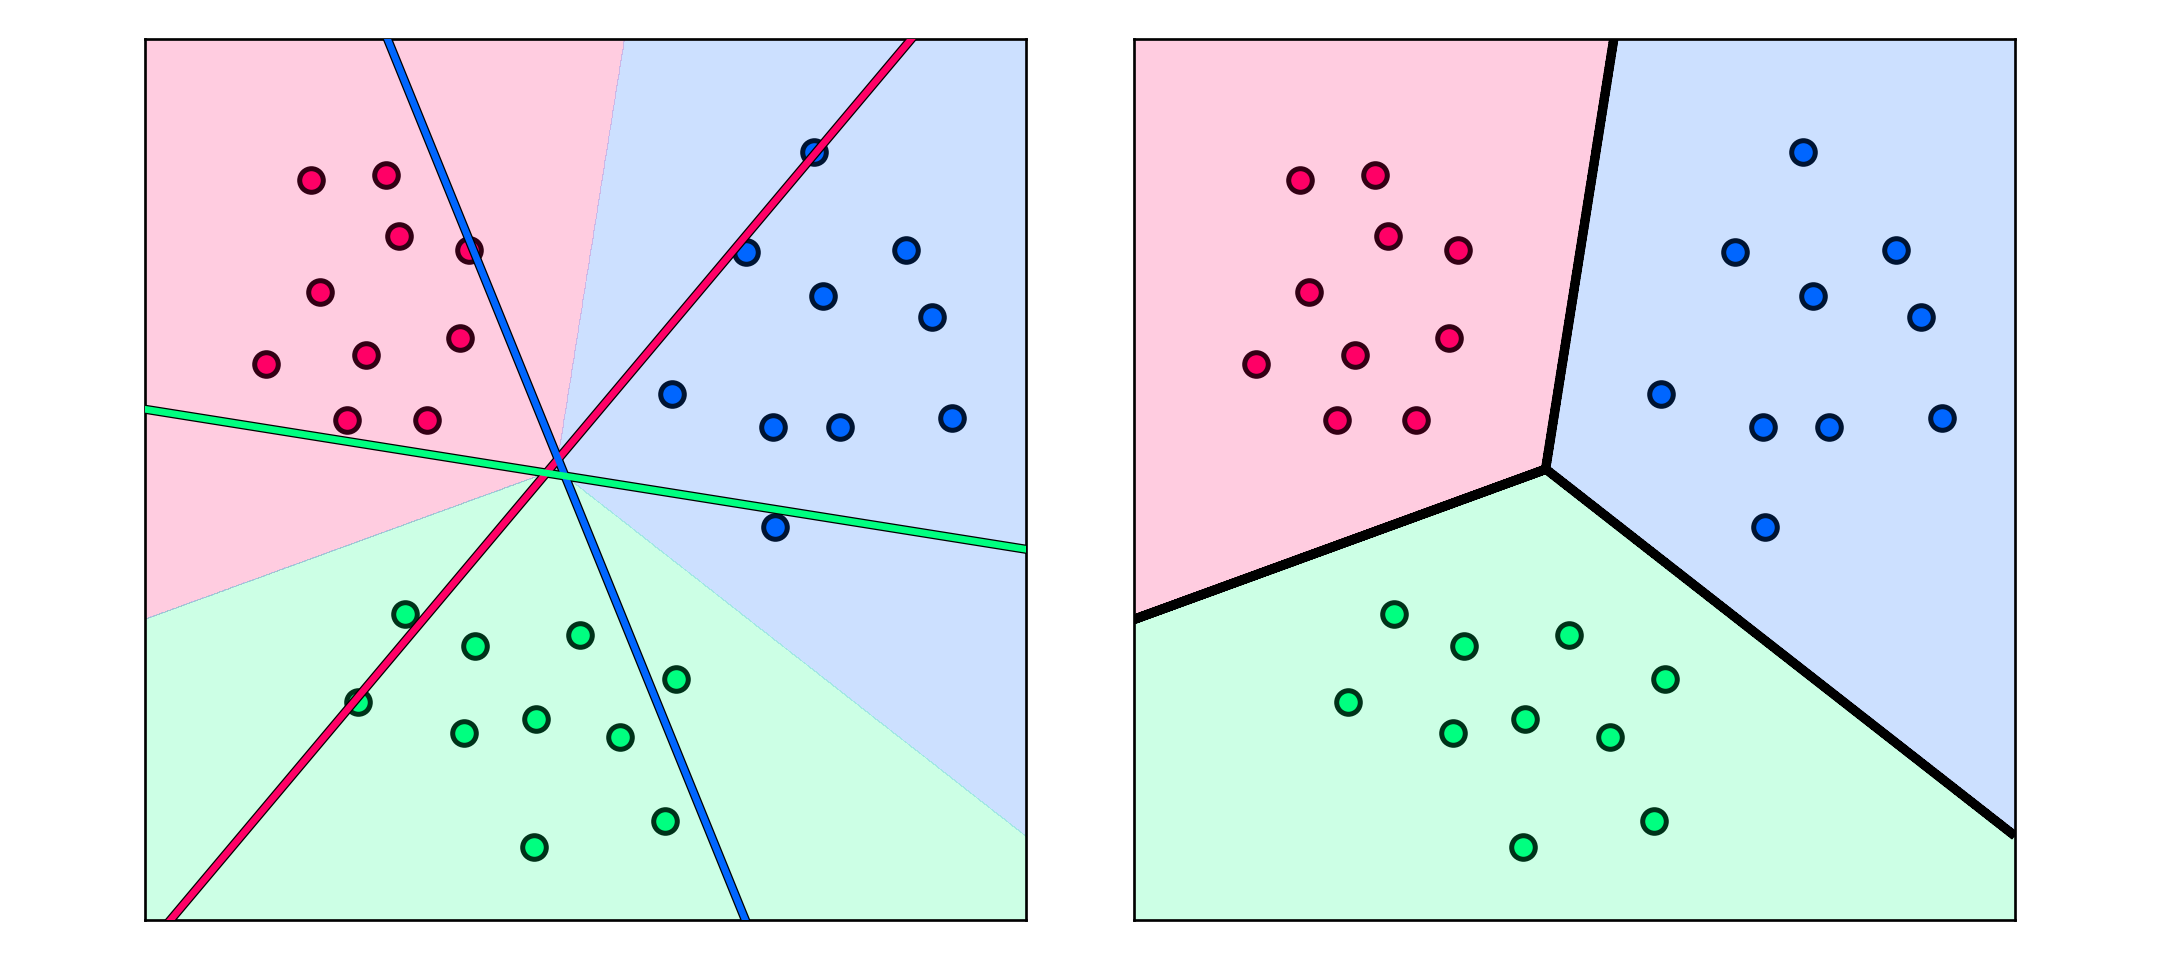

In [66]:
# This code cell will not be shown in the HTML version of this notebook
# load in dataset
data = np.loadtxt(datapath + '3class_data.csv',delimiter = ',')

# get input/output pairs
x = data[:-1,:]
y = data[-1:,:] 

# run gradient descent to minimize cost
g = multiclass_softmax; w = 0.1*np.random.randn(3,3); max_its = 200; alpha_choice = 1;
weight_history,cost_history = optimizers.gradient_descent(g,alpha_choice,max_its,w)

# create an instance of the ova demo
demo = superlearn.multiclass_illustrator.Visualizer(data)

# plot classification of space, individual learned classifiers (left panel) and joint boundary (middle panel), and cost-function panel in the right panel
demo.show_complete_coloring(weight_history, cost = multiclass_softmax)

Optimizing using Newton's method takes just a few steps: in the next cell we re-run the above experiment only using 5 Newton steps.

Below we then print out the same panels as previously, only displaying the results of Newton's method.  Using just a few steps we reach a far lower point on the multi-class softmax function - as can be seen by comparing the right panel below with the one shown previously with gradient descent.

<IPython.core.display.Javascript object>


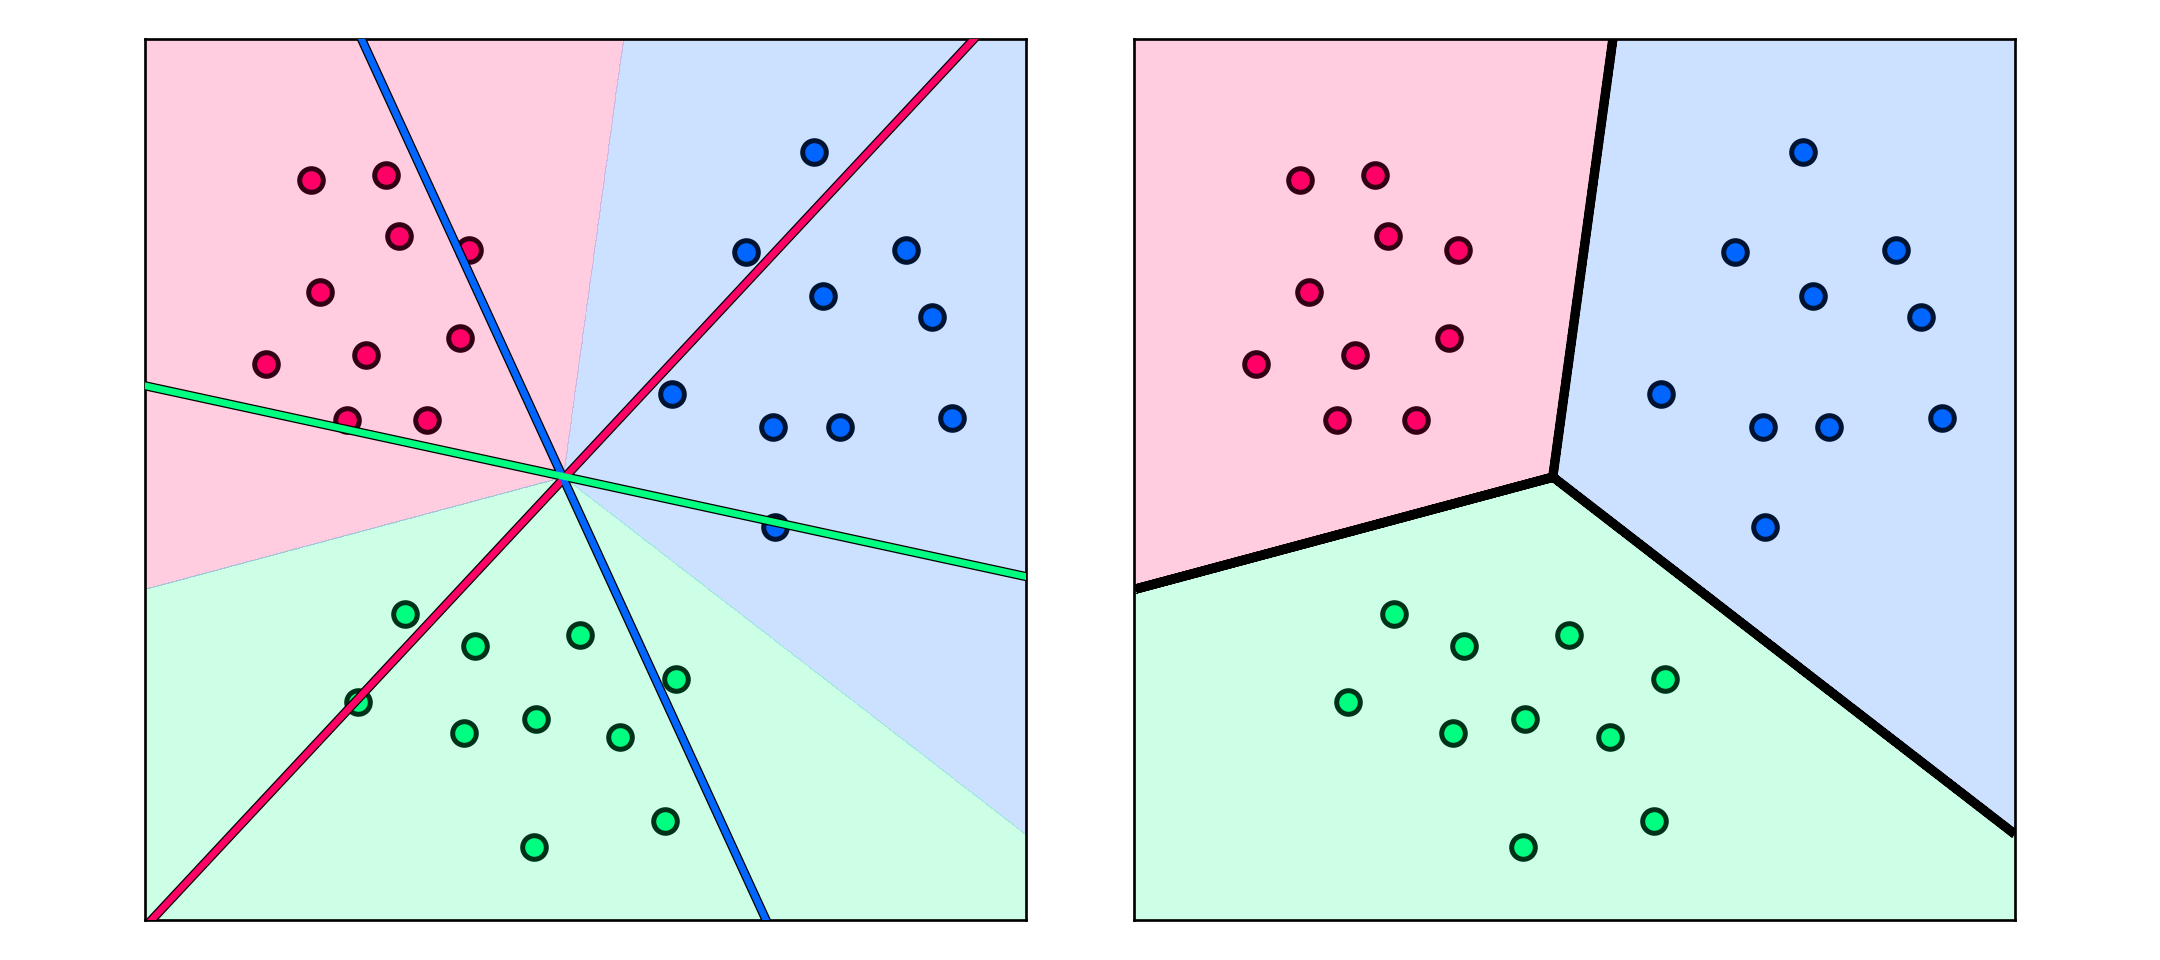

In [68]:
# This code cell will not be shown in the HTML version of this notebook
# run newtons method to minimize cost
g = multiclass_softmax; w = 0.1*np.random.randn(3,3); max_its = 5; 
weight_history,cost_history = optimizers.newtons_method(g,max_its,w)

# plot classification of space, individual learned classifiers (left panel) and joint boundary (middle panel), and cost-function panel in the right panel
demo.show_complete_coloring(weight_history, cost = multiclass_softmax)

#### <span style="color:#a50e3e;">Example 4: </span>  The multilevel step function produced by the fusion rule

As we saw in the previous Section the fusion rule - armed with trained weights - produces a multilevel step function (or *regressor*) to represent multiclass data.  In the Python cell below we show both perspectives - the 'regression' perspective viewing our data from the side, and the view 'from above' looking down onto the input space where use color to represent each class - side-by-side using our toy $C=3$ class dataset.  The boundaries we plot in the input space correspond directly to where this multilevel step function changes levels.

<IPython.core.display.Javascript object>


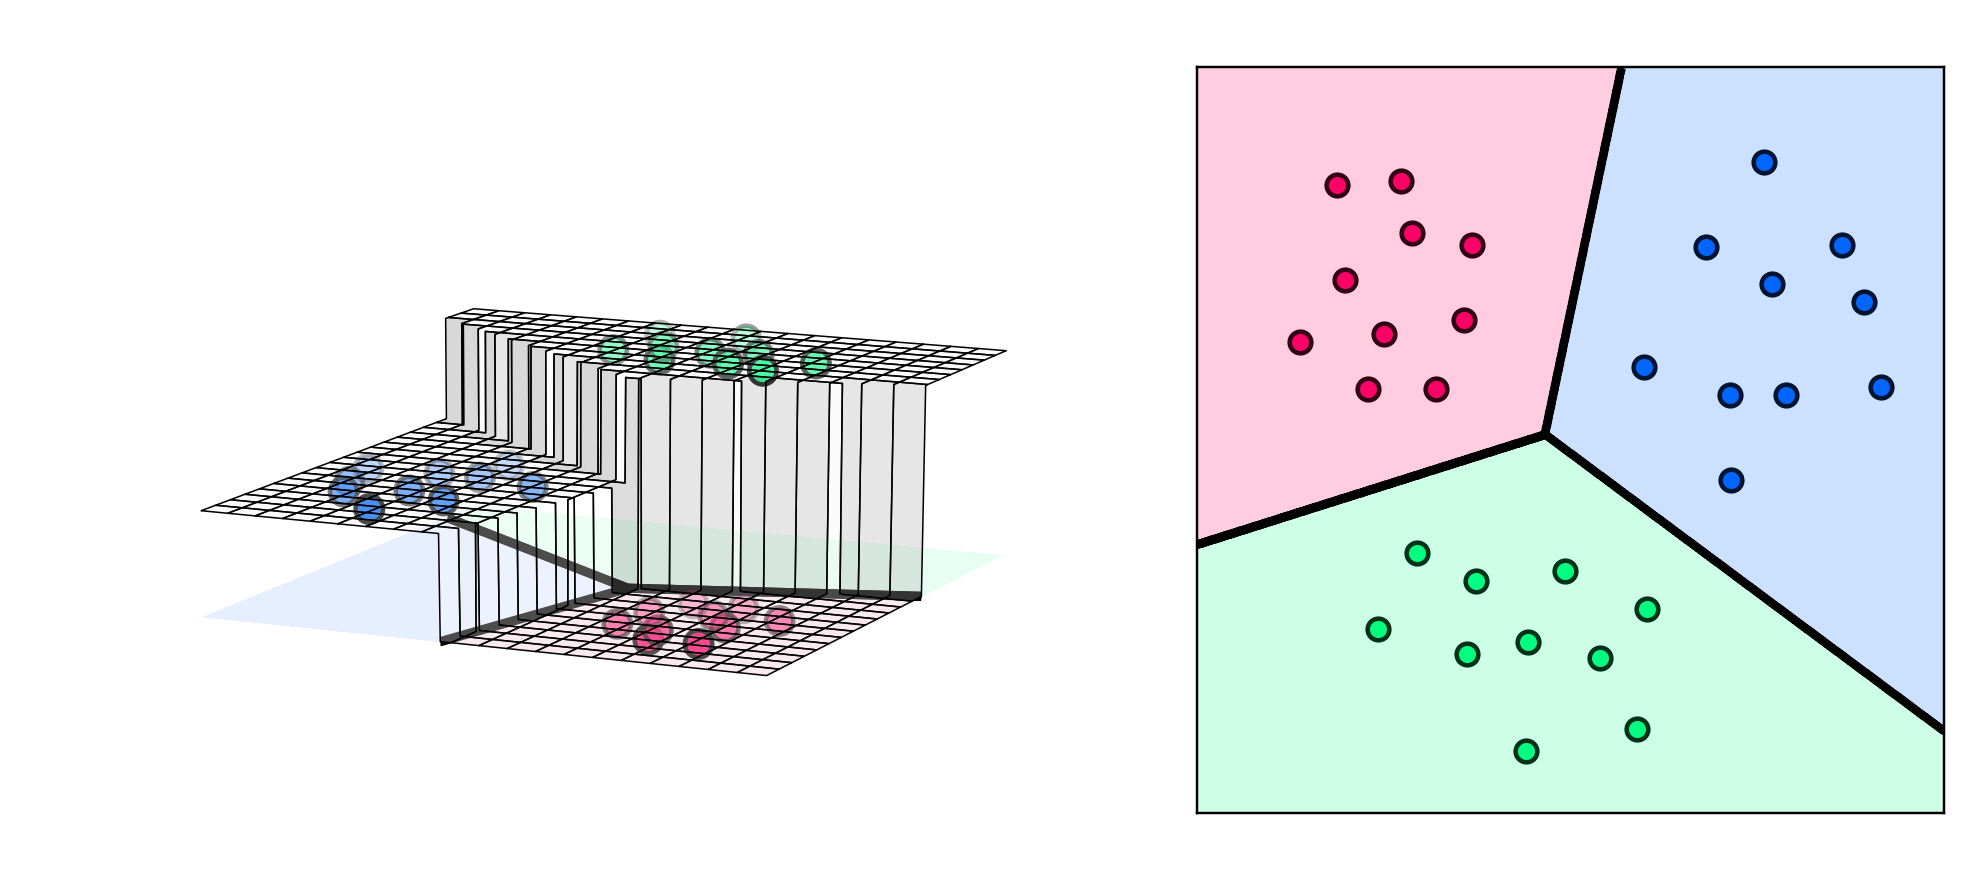

In [23]:
# This code cell will not be shown in the HTML version of this notebook
# plot classification of space, individual learned classifiers (left panel) and joint boundary (middle panel), and cost-function panel in the right panel
demo.show_surface_fit(weight_history,view = [15,115])

#### <span style="color:#a50e3e;">Example 5: </span> Multi-class softmax on a toy dataset with $C = 4$ classes

Here we quickly apply Newton's method to fit the multi-class softmax cost to our toy dataset with $C=4$ classes.

<IPython.core.display.Javascript object>


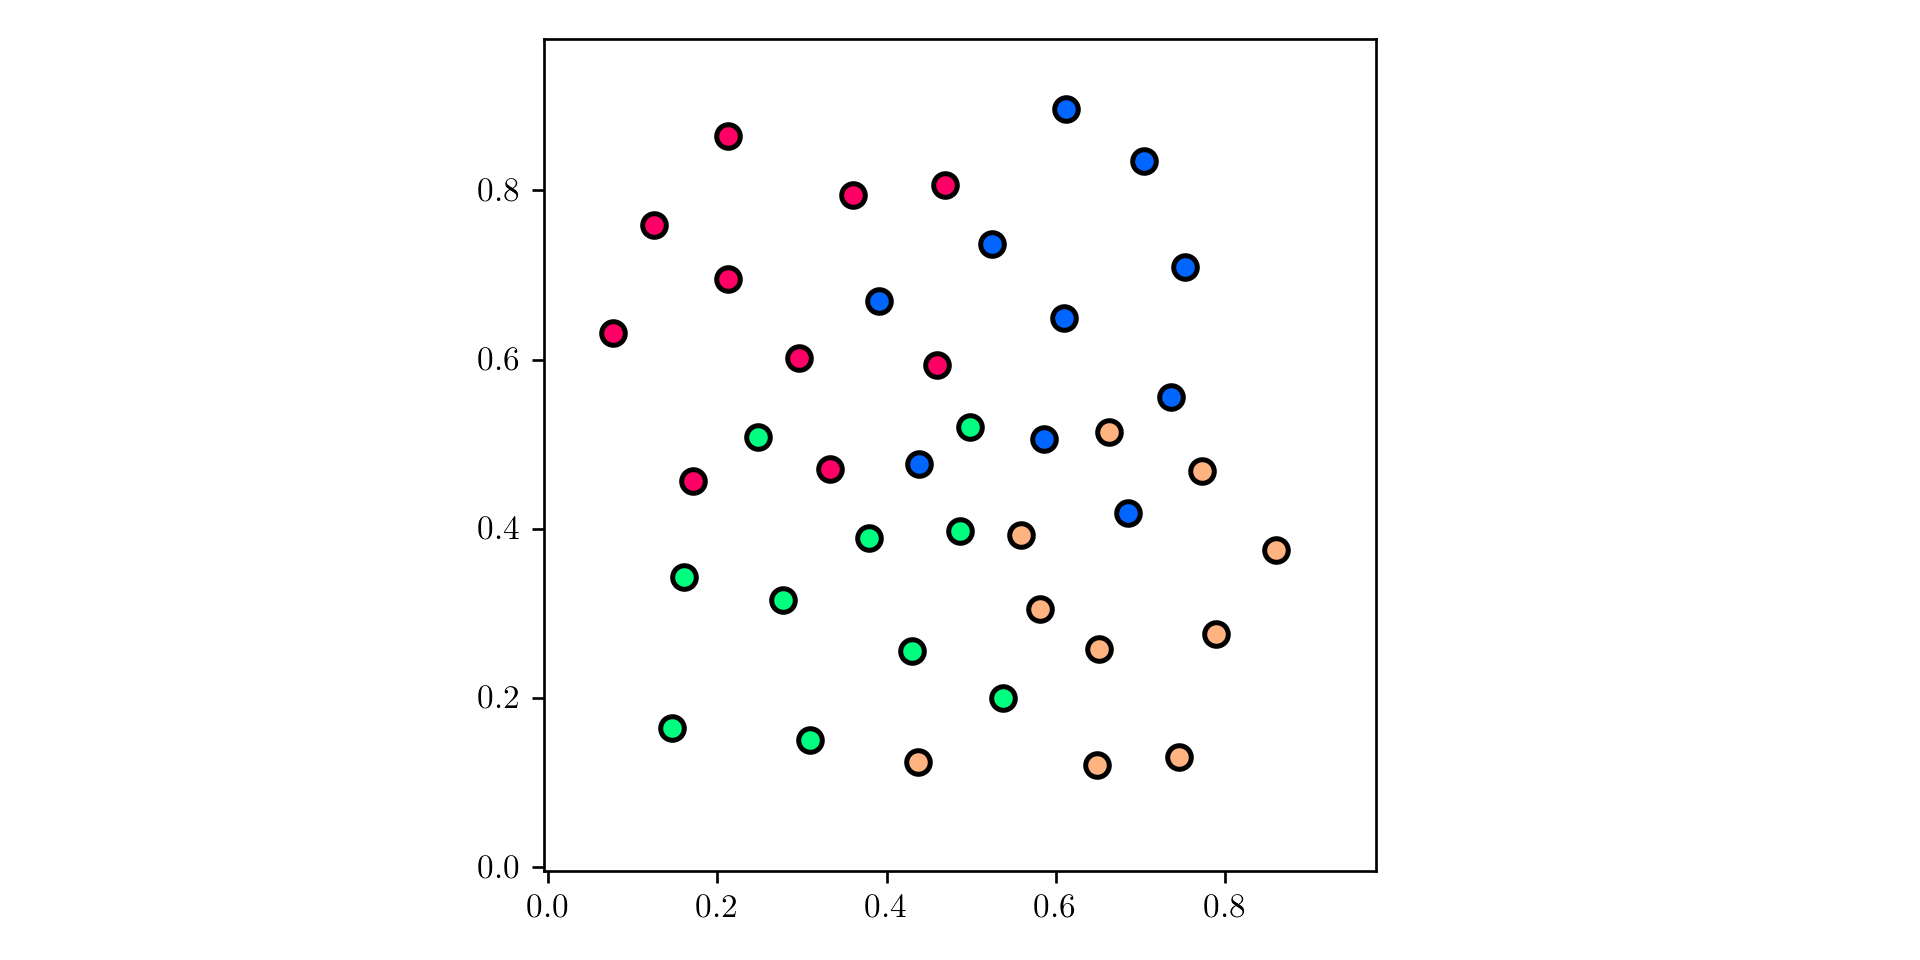

In [69]:
# This code cell will not be shown in the HTML version of this notebook
# load in dataset
data = np.loadtxt(datapath + '4class_data.csv',delimiter = ',')

# get input/output pairs
x = data[:-1,:]
y = data[-1:,:] 

# create an instance of the ova demo
demo = superlearn.multiclass_illustrator.Visualizer(data)

# visualize dataset
demo.show_dataset()

# run gradient descent to minimize cost
g = multiclass_softmax; w = 0.1*np.random.randn(3,4); max_its = 5; 
weight_history,cost_history = optimizers.newtons_method(g,max_its,w)

Finally, we plot our results, as in the previous Example.

<IPython.core.display.Javascript object>


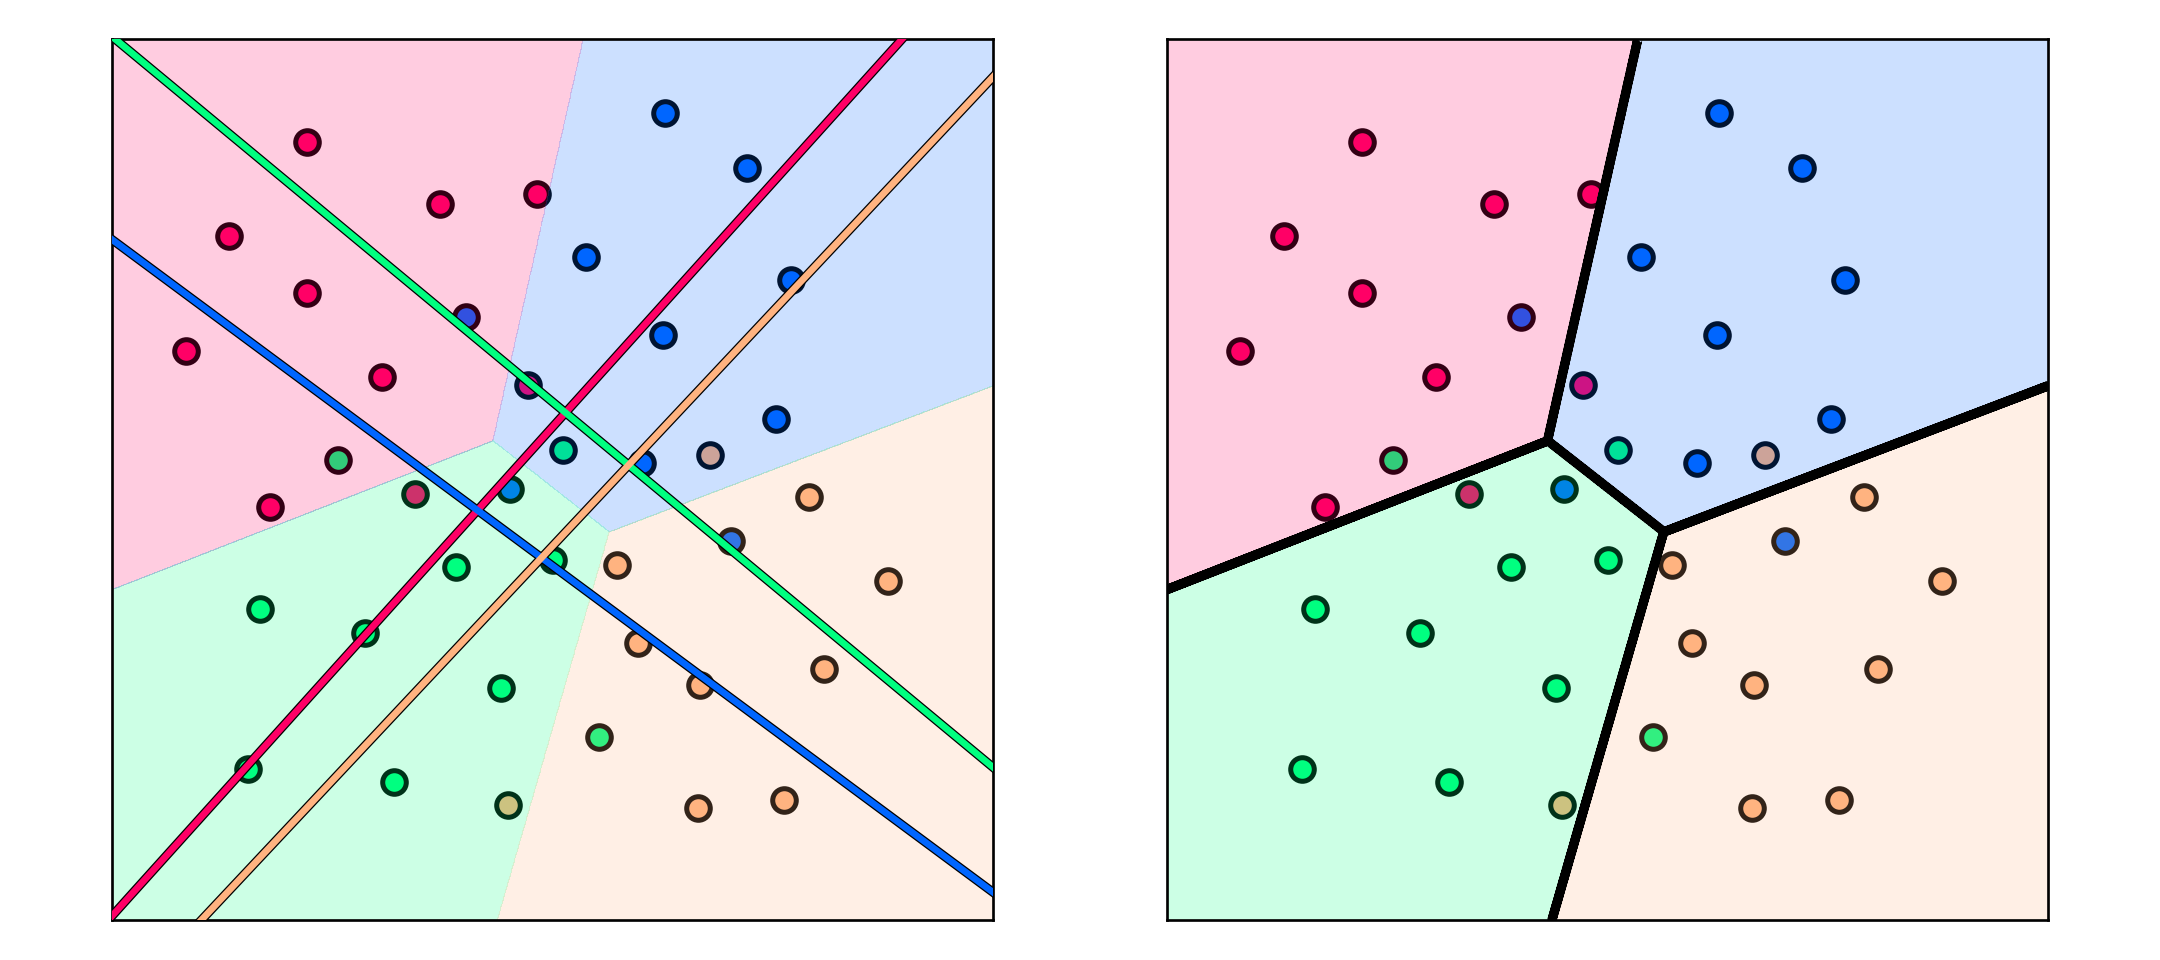

In [71]:
# This code cell will not be shown in the HTML version of this notebook
# plot classification of space, individual learned classifiers (left panel) and joint boundary (middle panel), and cost-function panel in the right panel
demo.show_complete_coloring(weight_history, cost = multiclass_softmax)

## 10.2.5  Counting misclassifications and the accuracy of a multi-class classifier

We do this the same way we do with OvA as detailed in the previous Section, however here we can show off a nice `Python` implementation using the `model` function above.

Once trained we can compute predicted labels for our training set by simply evaluating each input via the fusion rule.  Taking the input of the $p^{th}$ point $\left(\mathbf{x}_p,\,y_p\right)$ we use the fusion rule to produce a predicted output $\hat y_p$ as

\begin{equation}
\hat y_p =  \underset{j=0,...,C-1}{\text{argmax}} \,\,\,w_0^{(j)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(j)}
\end{equation}

We can write the fusion rule equivalently via our more compact linear `model` notation established above in Section 10.2.2, in which all $C$ linear combinations above are expressed as $\text{model}\left(\mathbf{x}_p,\mathbf{W}\right) = \mathbf{x}_p^T\mathbf{W}^{\,}$.  For any input $\mathbf{x}_p$ the output here is a $1\times C$ vector whose $j^{th}$ coordinate is precisely $w_0^{(j)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(j)}$.  With this notation we can write the fusion rule as 

\begin{equation}
\hat y_p =  \underset{j=0,...,C-1}{\text{argmax}} \,\, \text{model}\left(\mathbf{x}_p,\mathbf{W}\right)
\end{equation}

To count the number of mislcassifications on a training set we can then simply compare the actual and predicted labels over the data 

\begin{equation}
 \sum_{p = 1}^{P} \left | \text{sign}\left(\hat y_p - \overset{\mathstrut}{y_p}\right) \right | =  \sum_{p = 1}^{P} \left | \text{sign}\left(\text{model}\left(\mathbf{x}_p,\mathbf{W}\right) - \overset{\mathstrut}{y_p}\right) \right |.
\end{equation}

Since we have already implemented the `model` function previously we can use it to implement this multiclass counting function `Python` as shown below.

In [72]:
# multiclass misclassification cost function 
def multiclass_counting_cost(w):                
    # pre-compute predictions on all points
    all_evals = model(x,w)

    # compute predictions of each input point
    y_predict = (np.argmax(all_evals,axis = 0))[np.newaxis,:]

    # compare predicted label to actual label
    count = np.sum(np.abs(np.sign(y - y_predict)))

    # return number of misclassifications
    return count

#### <span style="color:#a50e3e;">Example 6: </span> Comparing cost function and counting cost values

Below we compare the number of misclassifications versus the multi-class softmax cost with regularizer. In this instance $\lambda = 10^{-3}$ for three runs of unnormalized gradient descent using a steplength parameter $\alpha = 10^{-2}$ for all three runs.

<IPython.core.display.Javascript object>


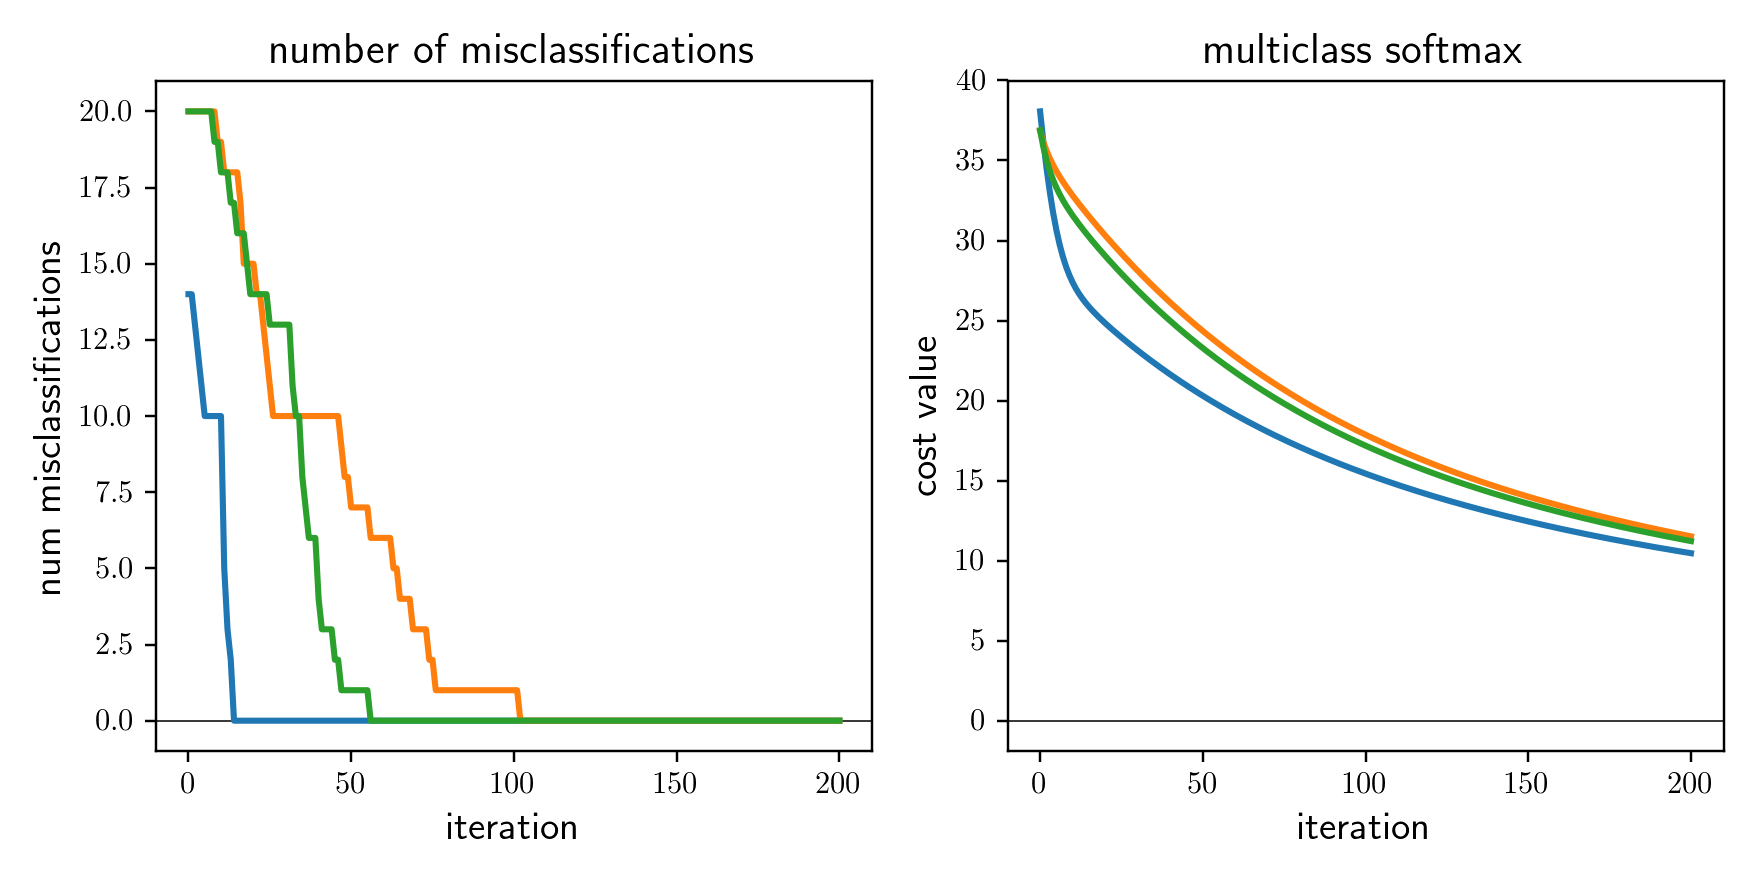

In [30]:
# This code cell will not be shown in the HTML version of this notebook
# load in dataset
data = np.loadtxt(datapath + '3class_data.csv',delimiter = ',')

# create an instance of the ova demo
demo = superlearn.multiclass_illustrator.Visualizer(data)

# run demo
demo.compare_to_counting(num_runs = 3)

## 10.2.6 Which multiclass classification scheme works best?

As we have now seen, both OvA and multiclass perceptron/softmax approaches are built using the fusion rule given in equation (1). While the OvA approach aims to satisfy the fusion rule indirectly - tuning the parameters of each individual classifer one-at-a-time in a sequence of two class subproblems and then combining the results - the multiclass perceptron / softmax approach tunes all parameters of every individual classifier *simultaneously* in order to satisfy the fusion rule as best as possible.  Because the multiclass perceptron/softmax take a more holistic view of parameter tuning in order to the fusion rule they can - in principle - provide better performance.  Above in Example 2 we provided a toy example illustrating this advantage - in which we compared OvA and the multiclass perceptron approaches.  While this advantage is intuitive, in practice on real data both OvA and the multiclass perceptron/softmax often perform similarly well.  

> While the multiclass perceptron/softmax can in principle provide superior performance, since both aim at satisfying the fusion rule directly rather than indirectly as is the case with OvA, the multiclass perceptron/softmax and OvA frameworks generally perform similarly well in practice.

The two methods also largely differ in how they are applied in practice as well as their computational burden. In learning each of the $C$ linear separators individually the computation required for the OvA classifier is naturally parallelizable, as each linear separator can be learned independently of the rest. On the other hand, while both OvA and multiclass softmax may be naturally extended for use with nonlinear multiclass classification (as we will see in Chapter 12), the multiclass softmax scheme provides a more commonly used framework for performing nonlinear multi-class classification using neural networks.

## 10.2.7 Multi-class softmax from a probabilistic perspective

The probabilistic derivation of the multi-class softmax cost is very similar to that of the two-class softmax, discussed previously Section 9.1 on logistic regression. Once again, the data independence assumption allows us to simplify the joint likelihood as 

\begin{equation}
{\cal L}=\prod_{p=1}^{P}{\cal P}\left(y=y_{p}\,|\,\mathbf{x}_{p},\mathbf{W}\right)
\end{equation} 

where the matrix $\mathbf{W}$ is the collection of all classifier weights as defined in equation (7). Even though $y_p$ here takes one of $C>2$ classes, we can still use the same geometric argument made when we had only two classes in order to propose a functional form for ${\cal P}\left(y=y_{p}\,|\,\mathbf{x}_{p},\mathbf{W}\right)$. Specifically, we again connect the probability of a point $\mathbf{x}_p$ belonging to a certain class to the *signed* distance from $\mathbf{x}_p$ to that class' decision boundary. That is, the larger the (signed) distance the deeper into that class' subspace $\mathbf{x}_p$ lies, and hence the more confident we are about $\mathbf{x}_p$ belonging to that class.

Assuming all classifiers' normal vectors are normalized to have unit length, the signed distance from $\mathbf{x}_p$ to the $c^{th}$ decision boundary $w_0^{(c)}+\mathbf{x}^T\mathbf{w}^{(c)}=0$ is simply given by the evaluation of the decision boundary at $\mathbf{x}_p$, i.e., $w_0^{(c)}+\mathbf{x}_p^T\mathbf{w}^{(c)}$. 

Adopting our geometric argument we want to have

\begin{equation}
{\cal P}\left(y=0\,|\,\mathbf{x}_{p},\mathbf{W}\right)\propto w_0^{(0)}+\mathbf{x}_p^T\mathbf{w}^{(0)}\\
{\cal P}\left(y=1\,|\,\mathbf{x}_{p},\mathbf{W}\right)\propto w_0^{(1)}+\mathbf{x}_p^T\mathbf{w}^{(1)}\\
\vdots\\
{\cal P}\left(y=C-1\,|\,\mathbf{x}_{p},\mathbf{W}\right)\propto w_0^{(C-1)}+\mathbf{x}_p^T\mathbf{w}^{(C-1)}
\end{equation} 

or put into words, that the probability of $\mathbf{x}_p$ belonging to class $c$ to be proportional to its signed distance to the $c^{th}$ decision boundary. These signed distances however can be negative and hence cannot be used immediately as class probabilities. We can resolve this issue by passing them through an always-positive and monotonically-increasing function such as $e^{\left(\cdot \right)}$ to get


\begin{equation}
{\cal P}\left(y=0\,|\,\mathbf{x}_{p},\mathbf{W}\right)\propto e^{w_0^{(0)}+\mathbf{x}_p^T\mathbf{w}^{(0)}}\\
{\cal P}\left(y=1\,|\,\mathbf{x}_{p},\mathbf{W}\right)\propto e^{w_0^{(1)}+\mathbf{x}_p^T\mathbf{w}^{(1)}}\\
\vdots\\
{\cal P}\left(y=C-1\,|\,\mathbf{x}_{p},\mathbf{W}\right)\propto e^{w_0^{(C-1)}+\mathbf{x}_p^T\mathbf{w}^{(C-1)}}
\end{equation} 

One issue still remains and that is $e^{w_0^{(c)}+\mathbf{x}_p^T\mathbf{w}^{(c)}}$ can potentially be larger than one and hence not a valid probability. Luckily there is a simple fix for this issue as well: divide all values by $\sum_{j=0}^{C-1}  e^{ w_0^{(j)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(j)}}$


\begin{equation}
{\cal P}\left(y=0\,|\,\mathbf{x}_{p},\mathbf{W}\right) \propto \frac{e^{w_0^{(0)}+\mathbf{x}_p^T\mathbf{w}^{(0)}}}{\sum_{j=0}^{C-1}  e^{ w_0^{(j)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(j)}}}\\
{\cal P}\left(y=1\,|\,\mathbf{x}_{p},\mathbf{W}\right) \propto \frac{e^{w_0^{(1)}+\mathbf{x}_p^T\mathbf{w}^{(1)}}}{\sum_{j=0}^{C-1}  e^{ w_0^{(j)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(j)}}}\\
\vdots\\
{\cal P}\left(y=C-1\,|\,\mathbf{x}_{p},\mathbf{W}\right)\propto \frac{e^{w_0^{(C-1)}+\mathbf{x}_p^T\mathbf{w}^{(C-1)}}}{\sum_{j=0}^{C-1}  e^{ w_0^{(j)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(j)}}}
\end{equation} 

Notice that all right hand side values now lie between $0$ and $1$, and moreover, they all add up to $1$ making them mathematically valid values to represent the class probabilities. Plugging   

\begin{equation} 
{\cal P}\left(y=y_p\,|\,\mathbf{x}_{p},\mathbf{W}\right) = \frac{e^{w_0^{(y_p)}+\mathbf{x}_p^T\mathbf{w}^{(y_p)}}}{\sum_{j=0}^{C-1}  e^{ w_0^{(j)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(j)}}}
\end{equation} 

into the likelihood in equation (16) and taking the negative logarithm of the resulting function gives the multi-class negative log-likelihood loss 

\begin{equation}
g\left(\mathbf{W} \right) = -\sum_{p = 1}^P \text{log}\left(\frac{ e^{ w_0^{(y_p)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(y_p)}} }{ \sum_{j = 0}^{C-1}  e^{ w_0^{(j)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(j)}} }\right)
\end{equation}

to be minimized. It should come as no surprise that this is precisely the multi-class softmax cost we derived previously in equation (12). 

## 10.2.8 Appendix

## Multi-class perceptron reduces to two-class perceptron when $C = 2$

When $C=2$ the multi-class perceptron cost in equation (4) reduces to 

\begin{equation}
g\left(w_0^{(0)},\,\mathbf{w}_{\mathstrut}^{(0)},\,w_0^{(1)},\,\mathbf{w}_{\mathstrut}^{(1)} \right) = \sum_{p = 1}^P \left[\,{\text{max}} \left(w_0^{(0)} + \mathbf{x}_{p}^T\mathbf{w}^{(0)},\,w_0^{(1)} + \mathbf{x}_{p}^T\mathbf{w}^{(1)}\right) - \left(w_0^{(y_p)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(y_p)}\right) \right]
\end{equation}

which, using the following equality for any real values $a$, $b$, and $c$   

\begin{equation}
{\text{max}} \left(a,b\right) - c = {\text{max}} \left(a-c,b-c\right)
\end{equation}

can be written equivalently as 



\begin{equation}
g\left(w_0^{(0)},\,\mathbf{w}_{\mathstrut}^{(0)},\,w_0^{(1)},\,\mathbf{w}_{\mathstrut}^{(1)} \right) = \sum_{p = 1}^P {\text{max}} \left(w_0^{(0)} + \mathbf{x}_{p}^T\mathbf{w}^{(0)}- \left(w_0^{(y_p)} + \mathbf{x}_{p}^T\mathbf{w}^{(y_p)}\right), \,w_0^{(1)} + \mathbf{x}_{p}^T\mathbf{w}^{(1)}- \left(w_0^{(y_p)} + \mathbf{x}_{p}^T\mathbf{w}^{(y_p)}\right)\right) 
\end{equation}

Grouping the summands according to their labels, we have 

\begin{equation}
g\left(w_0^{(0)},\,\mathbf{w}_{\mathstrut}^{(0)},\,w_0^{(1)},\,\mathbf{w}_{\mathstrut}^{(1)} \right) = \sum_{p:\, y_p = 0} {\text{max}} \left(0, \,w_0^{(1)}-w_0^{(0)} + \mathbf{x}_{p}^T\left(\mathbf{w}^{(1)}-\mathbf{w}^{(0)}\right)\right)\\
+ \sum_{p:\, y_p = 1} {\text{max}} \left(0, \,w_0^{(0)}-w_0^{(1)} + \mathbf{x}_{p}^T\left(\mathbf{w}^{(0)}-\mathbf{w}^{(1)}\right)\right)
\end{equation}

Re-assigning the labels $y_p=0 \rightarrow y_p=-1$ and $y_p=1 \rightarrow y_p=+1$ to match the label values we used in deriving the two-class perceptron, we can write

\begin{equation}
g\left(w_0^{(-1)},\,\mathbf{w}_{\mathstrut}^{(-1)},\,w_0^{(+1)},\,\mathbf{w}_{\mathstrut}^{(+1)} \right) = \sum_{p:\, y_p = -1} {\text{max}} \left(0, \,w_0^{(+1)}-w_0^{(-1)} + \mathbf{x}_{p}^T\left(\mathbf{w}^{(+1)}-\mathbf{w}^{(-1)}\right)\right) \\+ \sum_{p:\, y_p = +1} {\text{max}} \left(0, \,w_0^{(-1)}-w_0^{(+1)} + \mathbf{x}_{p}^T\left(\mathbf{w}^{(-1)}-\mathbf{w}^{(+1)}\right)\right)
\end{equation}

Letting $w_0=w_0^{(+1)}-w_0^{(-1)}$ and $\mathbf{w}=\mathbf{w}^{(+1)}-\mathbf{w}^{(-1)}$, the above can be written as  

\begin{equation}
g\left(w_0,\mathbf{w} \right) = \sum_{p:\, y_p = -1} {\text{max}} \left(0, \,w_0 + \mathbf{x}_{p}^T\mathbf{w}\right) + \sum_{p:\, y_p = +1} {\text{max}} \left(0, \,-w_0 - \mathbf{x}_{p}^T\mathbf{w}\right)
\end{equation}

This can be written more compactly to arrive at the familiar two-class perceptron cost function

\begin{equation}
g\left(w_0,\mathbf{w} \right) = \sum_{p=1}^P {\text{max}} \left(0, -y_p\left(w_0 + \mathbf{x}_{p}^T\mathbf{w}\right)\right) 
\end{equation}

## Multi-class logistic regression reduces to two-class logistic regression when $C = 2$

When $C=2$ the multi-class softmax cost in equation (12) reduces to 

\begin{equation}
g\left(w_0^{(0)},\,\mathbf{w}_{\mathstrut}^{(0)},\,w_0^{(1)},\,\mathbf{w}_{\mathstrut}^{(1)} \right) = \sum_{p = 1}^P \text{log}\left(\frac{ e^{ w_0^{(0)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(0)}} +e^{ w_0^{(1)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(1)}}  }{ e^{ w_0^{(y_p)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(y_p)}} }\right)
\end{equation}

Grouping the summands according to their labels, we have 

\begin{equation}
g\left(w_0^{(0)},\,\mathbf{w}_{\mathstrut}^{(0)},\,w_0^{(1)},\,\mathbf{w}_{\mathstrut}^{(1)} \right) = \sum_{p:\, y_p = 1} \text{log}\left( 1 + e^{w_0^{(1)}-w_0^{(0)} + \mathbf{x}_{p}^T \left(\mathbf{w}^{(1)}-\mathbf{w}^{(0)}\right)} \right) \\+ \sum_{p:\, y_p = 2} \text{log}\left( 1 + e^{w_0^{(0)}-w_0^{(1)} + \mathbf{x}_{p}^T \left(\mathbf{w}^{(0)}-\mathbf{w}^{(1)}\right)} \right) 
\end{equation}

Re-assigning the labels $y_p=0 \rightarrow y_p=-1$ and $y_p=1 \rightarrow y_p=+1$ to match the label values we used in deriving the two-class softmax cost previously, we can write

\begin{equation}
g\left(w_0^{(-1)},\,\mathbf{w}^{(-1)},\,w_0^{(+1)},\,\mathbf{w}_{\mathstrut}^{(+1)} \right)  = \sum_{p:\, y_p = -1} \text{log}\left( 1 + e^{w_0^{(+1)}-w_0^{(-1)} + \mathbf{x}_{p}^T \left(\mathbf{w}^{(+1)}-\mathbf{w}^{(-1)}\right)} \right) \\+ \sum_{p:\, y_p = +1} \text{log}\left( 1 + e^{w_0^{(-1)}-w_0^{(+1)} + \mathbf{x}_{p}^T \left(\mathbf{w}^{(-1)}-\mathbf{w}^{(+1)}\right)} \right) 
\end{equation}

Letting $w_0=w_0^{(+1)}-w_0^{(-1)}$ and $\mathbf{w}=\mathbf{w}^{(+1)}-\mathbf{w}^{(-1)}$, the above can be written as  

\begin{equation}
g\left(w_0,\mathbf{w} \right)  = \sum_{p:\, y_p = -1} \text{log}\left( 1 + e^{w_0 + \mathbf{x}_{p}^T\mathbf{w}} \right) + \sum_{p:\, y_p = +1} \text{log}\left( 1 + e^{-w_0 - \mathbf{x}_{p}^T \mathbf{w}} \right) 
\end{equation}

This can be written more compactly to arrive at the familiar two-class softmax cost function

\begin{equation}
g\left(w_0,\mathbf{w} \right) = \underset{p=1}{\overset{P}{\sum}}\mbox{log}\left(1+e^{-y_{p}\left(w_0+\mathbf{x}_{p}^{T}\mathbf{w}\right)}\right)
\end{equation}

## Multi-class perceptron and softmax costs are convex

Notice we always have that:
    
**I.** Addition of two (or more) convex functions is always convex.

**II.** Linear and affine functions are convex.

**III.** The max, exponential, and negative logarithm functions are all convex.

**IV.** Composition of two convex functions remains convex.

Each of the statements above can be verified easily using the following definition of convexity:

A function g is convex if and only if for all $\mathbf{w}_1$ and $\mathbf{w}_2$ in the domain of g and all $\lambda \in \left[0, 1\right]$, we have

\begin{equation}
g\left(\lambda \mathbf{w}_1+\left(1-\lambda\right) \mathbf{w}_2\right)\leq \lambda g\left(\mathbf{w}_1\right)+\left(1-\lambda\right) g\left(\mathbf{w}_2\right)
\end{equation}


With these four statements at hand, it is straight-forward to prove convexity of multi-class perceptron and softmax cost functions. 